# Machine learning technique for signal-background separation of nuclear interaction vertices in the CMS detector <a class="anchor" id="Top"></a>

Phil Baringer: baringer@ku.edu, Anna Kropivnitskaya (speaker): kropiv@cern.ch 
<br>
University of Kansas
<br>
_for CMS Collaboration_

## Abstract:
The CMS inner tracking system is a fully silicon-based high precision detector. Accurate knowledge of the positions of active and inactive elements is important for simulating the detector, planning detector upgrades, and reconstructing charged particle tracks. Nuclear interactions of hadrons with the detector material create secondary vertices whose positions map the material with a sub-millimeter precision in situ, while the detector is collecting data from LHC collisions. 

A neural network (NN) with two hidden layers was used to separate secondary vertices due to combinatorial background from those arising from nuclear interactions with material. The NN was trained and tested on data from proton-proton collisions at a center-of-mass energy of 13 TeV, recorded in 2018 at the LHC. 

NN training is performed using Keras and Matplotlib in a Jupyter notebook. Secondary vertices in the training data are classified as signal or background, based on their geometrical position. Even though the variables used in training show only small differences between background and signal, the NN has impressive separation power. Hadrographies of the CMS inner tracker detector before and after background cleaning are presented.

## Table of contents

* [Introduction](#Intro)
* [CMS detectors](#CMSdet)
  * [Pixel detector](#PixelDet)
* [Nuclear interactions](#NIs) 
  * [Data selection and reconstruction](#Data)
  * [Toy Data](#ToyData)
  * [Connect/Generate data](#Import-data)
* [Neural network (NN) motivation and strategy](#NNmotivation)
* [Classification strategy for NN](#Classification)
  * [Set Signal and Background regions for beam pipe](#SetBP)
  * [Set Signal and Background regions for BPIX](#SetBPIX)
  * [Set Signal and Background regions for pixel support tube](#SetTube)
  * [Set Signal and Background regions  for rails, by using  x position of NI candidate](#SetRails)
  * [Classify NI candidates as Signal, as Background, and as Non-classified regions](#ClassifyEvents)
  * [Check classification result](#CheckClassification)
  * [Estimate background-signal ratio (B/S) of each signal region](#BkgEstimation) 
  * [Shuffle Data](#DataShufle)
  * [Sort track parameters by $p_T$ decreasing and normalize subleading $p_T$ tracks](#SortPt)
  * [Plot variables, injected to NN](#VariablesToNN)
  * [Divide data into Train and Test data sets](#DataSplit)
  * [Data preparation and classification for the NN](#FinalClassification)
* [Principal component analysis (PCA)](#PCA)
* [Keras mode: NN with 2 hidden layers](#KerasModel)
  * [Import libraries](#ImportKeras)
  * [Create function for NN model with 2 hidden layers](#NNfunction)
  * [Create NN model structure and compile it](#ModelCompile)
  * [NN model training](#ModelTraining)
  * [Save/Load NN model to/from file](#Save-Load-Model)
  * [Monitor performance during training](#MonitorTraining)
  * [Model results](#ModelResults)
     * [Predict the probability distribution of NN classes for Train and Test sets](#PredictY)
     * [The probability distribution for injected vertex to be a signal](#PlotY)
     * [NN model optimization with Test set](#YpredOptimization)
     * [Plot Train and Test prediction for Signal-Background separation as function of  BPIX radius](#PlotPredictedResultsR)
     * [Background to Signal (B/S) ratios in Signal regions (S0-S6)](#BSafterClass)
     * [Tracker tomography with Test set for Signal-Background separation in x-y plane](#PlotPredictedTomography)
* [Summary](#Summary)
* [Documentation](#Doc)
* [Acknowledgment](#Acknowledgment)


# Introduction <a class="anchor" id="Intro"></a>
[jump to top](#Top)

In HEP, very often problem of signal-background (noise) separation appears:
* resonance peak from decay particle,
* physics objects reconstruction/identification, for example, pions, photons, electrons, b(t)-jets… 
* nuclear interactions with material (this analysis),
* photon conversion with material,
which are on top of combinatorial background.

Very often, there is no clean sample of signal to train neural network (NN), but regions with enhanced contribution of signal could be known (by mass, geometrical, or any phase space cuts).

Machine learning technique of NN with floating classification could be helpful:
* Input classification is done on mixed samples with different fraction of background to signal.
* Output classification is optimized for real signal and combinatorial background separation.

This analysis is performed with [Jupyter notebook](http://ebooks.iospress.nl/publication/42900) 
at [SWAN](https://www.sciencedirect.com/science/article/abs/pii/S0167739X16307105?via%3Dihub) platform
and is based on the CMS public results, described in [link](https://twiki.cern.ch/twiki/bin/view/CMSPublic/TrackerMaterialNIwithML2018).

# CMS detectors <a class="anchor" id="CMSdet"></a>
[jump to top](#Top)

<p>
    <img src="./images/CMS_detector.png" width="800" alt>
    <em> $\bf{Fig. 1}$: CMS detectors.</em>
</p>

CMS detectors are designed to study different particle properties, created during p-p collisions, with high performance and  resolutions: 

* muon system detects and measures muons, 
* central tracking system gives accurate momentum measurements, 
* an electromagnetic calorimeter detects and measures electrons and photons,
* hadron calorimeter, designed to entirely surround the collision and prevent particles from escaping. 

In this analysis, material of [the pixel detector](#PixelDet) (part of the tracking system) is studied with [nuclear interactions](#NIs).

<a class="anchor" id="PixelDet"></a>
## Pixel detector 

Inner tracker system consists of pixel and strip detectors, 
which reconstruct charged particles momentum with high precision.

<p>
    <img src="images/PixelDetector.png" width="900" alt>
    <em> $\bf{Fig. 2}$: Pixel detector. </em>
</p>

Pixel detector consists of barrel pixel (BPIX) and forward pixel detectors.
Data from barrel region only are analyzed in this analysis. 

[jump to top](#Top)

<a class="anchor" id="NIs"></a>
# Nuclear interactions 

Nuclear interactions (NIs) are interactions of hadrons with the detector material, which create secondary vertices. For the physics analysis NIs play role of the background (noise) for the data. But, due to its interaction with material of the detector, position of these secondary vertices map the material with a sub-millimeter precision. Accurate knowledge of the positions of active and inactive elements is important for simulating the detector, planning detector upgrades, and reconstructing charged particle tracks.

<p>
    <img src="images/NIdefinition.png" width="300" alt>
    <em> $\bf{Fig. 3}$: Nuclear interaction schematic view. </em>
</p>

Example, of material mapping with NIs for BPIX detector is presented at Fig. 4, taken from [CERN-CMS-DP-2019-001](http://cds.cern.ch/record/2664786?ln=en). 

NI candidates reproduce inner tracker hadrography, but big combinatorial background from random vertices is observed near beam pipe, 1<sup>st</sup>, 2<sup>nd</sup> and 3<sup>rd</sup> layers of the barrel pixel (BPIX) detector.

<p>
    <img src="images/BPIXhadrography.png" width ="600" alt>
    <em> $\bf{Fig. 4}$: Hadrography of the tracking system in the x-y plane in the barrel region ($|z| < 25$ cm). The density of NI vertices reproduces structure of the BPIX detector. </em>
</p>

[jump to top](#Top)

<a class="anchor" id="Data"></a>
## Data selection and reconstruction

p-p collisions at 13 TeV from the single muon collection:
 
* Study with part of 2018 prompt-reconstructed data (4.3 fb<sup>-1</sup>)
* Nuclear interaction (NI) reconstruction technique is presented at:
  * [DOI:10.1088/1748-0221/13/10/P10034](http://dx.doi.org/10.1088/1748-0221/13/10/P10034)
  * [CERN-CMS-DP-2019-001](http://cds.cern.ch/record/2664786?ln=en)

* NI is a particle flow displaced vertex with following requirements:
  * at least 3 tracks incoming or outgoing from the vertex;
  * invariant mass of the outgoing system > 1 GeV to suppress light mesons, baryons, and photon conversions.

Only NI vertex candidates (NI candidates) from barrel region of the tracker detector (BPIX, |z| < 25 cm)  are analyzed: around 1.5×10<sup>6</sup> NI candidates.

[jump to top](#Top)

## Toy Data<a class="anchor" id="ToyData"></a>

There is no public CMS data sample for this notebook, so a Toy sample was generated in the next section:

* Background radius distribution was simulated with a non-central chi-squared shape.
* Signal radius distributions were simulated with Gaussian (normal) functions, except the rails simulation, which used a box-shape.
* Input variables for neural network:
   * were randomly generated using Gaussian distributions (mean, $\sigma$) with sigma taken from real data.
   * Mean value for signal and background was slightly scaled according to the radius of the NI candidate: mean*(1+Radius/50).
   * Mean value of the background was randomly varied between $\pm(0.4\sigma:0.5\sigma)$ about the mean value of the signal.

Results with CMS data are available in the notebook as an output, but, during presentation, Toy data will be used to show the notebook functionality.

[jump to top](#Top)

<a class="anchor" id="Import-data"></a>
## Connect/Generate data 

In [1]:
# DataType = "CMS"
DataType = "Toy" # for PyHEP only Toy could be used
#import matplotlib and numpy
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import logging, sys
from importlib import reload
reload(logging) # you need it if want switch logging level


#logging.basicConfig(stream=sys.stdout, level=logging.INFO) # it could make settings for all logger, what we don't want
logging.basicConfig(stream=sys.stdout) # it could make settings for all logger, what we don't want
#logging.disable(sys.maxsize) # desiable logging

logger = logging.getLogger('log')
# logger.setLevel(level=logging.DEBUG)
logger.setLevel(level=logging.INFO)

plt.rc('axes', labelsize = 15)
plt.rc('axes', titlesize= 17)
plt.rc('font', size=12) 
plt.rc('legend', fontsize=15)

# set CMS label at each plot:
if DataType == "Toy":
    labelData = "Toy Data"
    CMSlabel = "Generator"
    CMSlumi = " "
else:
    labelData = 'Data 2018, |z| < 25 cm'
    CMSlabel = "Preliminary"
    CMSlumi = " 4.3 fb$^{-1}$ (13 TeV) "
# CMSlabel = "internal"
def SetCMSlabel(px, label = CMSlabel, size = 17, label_lumi = CMSlumi):
    if DataType == "Toy":
        TitleCMS = r"$\bf{Toy}$"+" "+r"$\it{"+label+"}$"
    else:
        TitleCMS = r"$\bf{CMS}$"+" "+r"$\it{"+label+"}$"
    text = px.text(0.,1.,TitleCMS, size = size, transform=px.transAxes,
                           verticalalignment='bottom', horizontalalignment='left')
    text2 = px.text(1.,1.,label_lumi, size = size, transform=px.transAxes,
                           verticalalignment='bottom', horizontalalignment='right')
    return text, text2

def CalcRad(xpos, ypos):
    Rad = np.sqrt(np.square(xpos)+np.square(ypos))
    Rad_BP = np.sqrt(np.square(xpos-0.171)+np.square(ypos+0.176))
    Rad_BPIX = np.sqrt(np.square(xpos-0.086)+np.square(ypos+0.102))
    Rad_Tube = np.sqrt(np.square(xpos+0.080)+np.square(ypos+0.318))
    return Rad, Rad_BP, Rad_BPIX, Rad_Tube

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

# connect data
if DataType == "Toy":
    
    np.random.seed(10) # to fix random generator
    scale = 1 # (should be int) scale amount of your Toy Data
    Diff_SB = 0.5 # variation of background mean by \pm Diff_SB*sigma 
    Diff_SB_min = 0.4

    def StructureGen(pos, lw, lw_corr, ngen, x0, y0):
        lenth = np.size(ngen)
        for i in range(0,lenth):
            r_gen = np.random.normal(loc=pos[i], scale=lw[i]/lw_corr[i], size=ngen[i])
            phi_gen = np.random.uniform(low=-np.pi, high=np.pi, size=ngen[i])
            x_gen = np.multiply(r_gen, np.cos(phi_gen)) + x0
            y_gen = np.multiply(r_gen, np.sin(phi_gen)) + y0
            z_gen = np.random.uniform(low=-25., high=25., size=ngen[i])
            if i == 0:
                x_str, y_str, z_str = x_gen, y_gen, z_gen
            else:
                x_str = np.concatenate(([x_str,x_gen]),axis=0)
                y_str = np.concatenate(([y_str,y_gen]),axis=0)
                z_str = np.concatenate(([z_str,z_gen]),axis=0)
        return x_str, y_str, z_str

    def varGen(varName, varMean, varSigma, Rad):
        var_lenth = np.size(varName)
        logger.debug("var_lenth size = " + str(np.size(varName)))
        sample_size = np.size(Rad)
        for i in range(0,var_lenth):
            varM = varMean[i]*(1. + Rad/50.) # small scale: with Raduis variable are changes slightly Rad between 0 and 25
            varS = varSigma[i]*(1. + Rad/50.)
    #         print("varM shape = " + str(varM.shape))
            var_gen = np.random.normal(loc=varM, scale=varS, size=sample_size)
            if i == 0:
                var_tot = var_gen
            else:
                var_tot = np.c_[var_tot,var_gen]

        return var_tot

    # generate background:
    # https://en.wikipedia.org/wiki/Noncentral_chi-squared_distribution
    n_bkg = 400000*scale
    r_bkg   = np.random.noncentral_chisquare(df=3, nonc=2, size=n_bkg)
    r_bkg   = r_bkg + 1.
    phi_bkg = np.random.uniform(low=-np.pi, high=np.pi, size=n_bkg)
    x_bkg = np.multiply(r_bkg, np.cos(phi_bkg))
    y_bkg = np.multiply(r_bkg, np.sin(phi_bkg))
    z_bkg = np.random.uniform(low=-25., high=25., size=n_bkg)

    # beam pipe position and Radius is taken from CMS-DP-2019-001 (http://cds.cern.ch/record/2664786?ln=en)
    # generate beam pipe (BP):
    n_BP = [30000*scale]
    # in R_BP centered at BP
    xSignal_BP =    [2.21]
    lw_Signal_BP =  [0.1]
    lw_corr_BP =    [3.5]
    x0_BP, y0_BP = 0.171, -0.176
    x_BP, y_BP, z_BP = StructureGen(xSignal_BP, lw_Signal_BP, lw_corr_BP, n_BP, x0_BP, y0_BP)


    # BPIX position is taken from Figure. 4.1 at CMS-TDR-11 (https://cds.cern.ch/record/1481838?ln=en)
    # generate BPIX:  
    #          Inner Shield      L1_1    L1_2    L2_1  L2_2     L3_1   L3_2      L4_1   L4_2   Outer Shield      
    xSignal_BPIX =   [2.49,        2.8,     3.10,   6.65, 6.98,    10.80, 11.10,    15.84, 16.13, 18.65]
    lw_Signal_BPIX =  [0.055,    0.2,    0.2,    0.2,  0.2,     0.2,  0.2,   0.2,    0.2,   0.2]
    lw_corr_BPIX  =   [2.,        3.,      6.,    3.,     6.,    3.,      3.,   3.,     3.,    3.]
    n_BPIX =       [2000,        10000,   5000,   8000, 3500,  4000,  4000,     3000, 3000,   1000]
    logger.debug("n_BPIX  befor = " +str(n_BPIX ))
    n_BPIX = np.multiply(n_BPIX,scale)
    logger.debug("n_BPIX  after = " +str(n_BPIX ))

    x0_BPIX, y0_BPIX = 0.086, -0.102
    x_BPIX, y_BPIX, z_BPIX = StructureGen(xSignal_BPIX, lw_Signal_BPIX, lw_corr_BPIX, n_BPIX, x0_BPIX, y0_BPIX)

    #tube position and Radius is taken from CMS-DP-2019-001 (http://cds.cern.ch/record/2664786?ln=en)
    # generate Tube:
    xSignal_Tube   =  [21.75] # avarige of Rx and Ry
    lw_Signal_Tube =  [0.4]
    lw_corr_Tube =    [3.5]
    n_Tube = [10000*scale]
    x0_Tube, y0_Tube = -0.080, -0.318
    x_Tube, y_Tube, z_Tube = StructureGen(xSignal_Tube, lw_Signal_Tube, lw_corr_Tube, n_Tube, x0_Tube, y0_Tube)

    #Rails position and Radius is taken from CMS-DP-2019-001 (http://cds.cern.ch/record/2664786?ln=en)
    # generate Rails:
    n_Rails = 1000*scale
    ySignal_TopRail = 19.08
    ySignal_BotRail = -19.73
    lw_yRail = 1.
    xmin, xmax = -5, 5
    x_TopRail = np.random.uniform(low=xmin, high=xmax, size=n_Rails)
    y_TopRail = np.random.uniform(low=ySignal_TopRail, high=(ySignal_TopRail+lw_yRail), size=n_Rails)
    z_TopRail = np.random.uniform(low=-25., high=25., size=n_Rails)
    x_BotRail = np.random.uniform(low=xmin, high=xmax, size=n_Rails)
    y_BotRail = np.random.uniform(low=(ySignal_BotRail-lw_yRail), high=ySignal_BotRail, size=n_Rails)
    z_BotRail = np.random.uniform(low=-25., high=25., size=n_Rails)

    x_sig = np.concatenate(([x_BP,x_BPIX,x_Tube,x_TopRail,x_BotRail]),axis=0)
    y_sig = np.concatenate(([y_BP,y_BPIX,y_Tube,y_TopRail,y_BotRail]),axis=0)
    z_sig = np.concatenate(([z_BP,z_BPIX,z_Tube,z_TopRail,z_BotRail]),axis=0)
    x = np.concatenate(([x_bkg,x_sig]),axis=0)
    y = np.concatenate(([y_bkg,y_sig]),axis=0)
    z = np.concatenate(([z_bkg,z_sig]),axis=0)

    logger.debug("x shape = " +str(x.shape))
    logger.debug("y shape = " +str(y.shape))
    logger.debug("z shape = " +str(z.shape))

    lenth_sig = np.size(x_sig)
    lenth_bkg = np.size(x_bkg)
    
    # create 23 input variables with gaussian, the same sigma for S and B, but with some shift in mean for S and B 
    var_Name     =  np.asarray(["ver", "NI", "pT1","pT2", "pT3", "eta1", "eta2", "eta3", "phi1",  "phi2", "phi3", 
                     "chi2_1", "chi2_2", "chi2_3", "normchi2_1", "normchi2_2","normchi2_3",
                     "hits1","hits2", "hits3", "algo1", "algo2", "algo3"])
    # print("var_Name shape = " + str(var_Name.shape))
    var_Mean_Sig =  np.asarray([20.,   1.1,   1.5,  1.,    0.5,   0.,     0.,       0.,      0.,     0.,     0.,
                     20.,      15.,      12.,    1.2,         1.,          0.8,
                     20.,  15.,  10.,           10., 9., 8.])
    var_Sigma =     np.asarray([10.,   0.3,   0.3, 0.3,    0.3,   1.,    1.,       1.,   np.pi,  np.pi, np.pi,
                     10.,    8.,         5.,    0.5,          0.4,         0.3,
                     5.,   4.,    3.,           5.,  4., 3.])
    # variation of background mean by \pm (Diff_SB_min, Diff_SB)*sigma
    fracRandom = np.random.uniform(low=Diff_SB_min, high=Diff_SB, size=var_Sigma.size)
    IntRandom  = np.random.randint(2, size=var_Sigma.size) #genrate 0 or 1
    fracRandom[IntRandom==0] = -fracRandom[IntRandom==0]
    var_Mean_Bkg = var_Mean_Sig-np.multiply(fracRandom,var_Sigma)
    logger.info("Background mean value shift in $\sigma$ = " + str(fracRandom))

    # generate signal input variables:
    Radius = CalcRad(x_sig,y_sig)[0]
    var_Signal = varGen(var_Name, var_Mean_Sig, var_Sigma, np.asarray(Radius))

    # generate background input variables:
    Radius = CalcRad(x_bkg,y_bkg)[0]
    var_Bkg = varGen(var_Name, var_Mean_Bkg, var_Sigma, np.asarray(Radius))

    logger.debug("var_Signal shape = " + str(var_Signal.shape))
    logger.debug("var_Bkg shape = " + str(var_Bkg.shape))

    # merge Signal and Background
    var = np.r_[var_Bkg,var_Signal]
    logger.debug("var shape = " + str(var.shape))

    # merge var and positions 1st bkg, after signal
    num = np.asarray(range(0,np.size(x)))
    data = np.c_[num,np.asarray(x),np.asarray(y),np.asarray(z),var]
    print("Toy data.shape = " + str(data.shape))

else:
    data = np.genfromtxt("/eos/user/k/kropiv/root-files/NI/NN_X_2018D_barrel.csv", delimiter=',')
logger.info("shape of data = " + str(data.shape))


INFO:log:shape of data = (1397381, 27)


## Display generated Toy data:

In [2]:
if DataType == "Toy":
    # using the variable ax for single a Axes
    fig, (ax,bx) = plt.subplots(1,2, figsize=(17,7))
#     fig, ax = plt.subplots(figsize=(15,7))
    nb = 200

    Rad = CalcRad(x, y)[2] # 2nd element centered at BPIX
    cut = 23.
    Xmax = 25.
    xcut = x[Rad < cut]
    ycut = y[Rad < cut]
    # to add color pallete to figure: cmap = 'viridis' (default), 'jet'    
    counts, xedges, yedges, im = ax.hist2d(xcut, ycut, bins=nb, range = [[-Xmax, Xmax], [-Xmax, Xmax]], norm=LogNorm(),
                                          cmap = 'viridis')
    ax.set_xlabel('x (cm)')
    ax.set_ylabel('y (cm)')
    SetCMSlabel(ax) 
    ax_cbar = plt.colorbar(im, ax=ax)
    
    x_values = np.linspace(-1.5, 2, 100)
    for mu, sig in [(0, 0.5), (Diff_SB*0.5, 0.5)]:
        bx.plot(x_values, gaussian(x_values, mu, sig))
    bx.text(0.05, 0.9, "Gaussian",
                verticalalignment='bottom', horizontalalignment='left',
                transform=bx.transAxes, color='black', fontsize=15)
    bx.legend(['mean = 0', 'mean = 0.5$\sigma$'],loc="upper right",framealpha=1.)
        
    fig.tight_layout()
    plt.savefig('Results/Toy_Generator.pdf')
    plt.show()

# Neural network (NN) motivation and strategy <a class="anchor" id="NNmotivation"></a>

For each NI candidate, monitoring variables are available, which are very similar for real NIs (signal) and combinatorial background (background).

* Machine learning technique could be helpful for signal-background separation.
* NN with 2 hidden layer (with 12 neurons in each hidden layer) is selected:
 
* For simplicity, only vertices for NI candidate with exactly 3 tracks are used:
    1.4×10<sup>6</sup> (=3 tracks, majority of the vertices) from 1.5×10<sup>6</sup> (≥ 3 tracks) vertices.

* 23 variables are injected to the input layer of NN (23 input variables for NN):
  * number of primary vertices; 
  * number of NI candidates per one event; 
  * 3 tracks for each NI vertex candidate:
    * $p_T$, $\eta$, and $\phi$;
    * $\chi^2$, and normalized $\chi^2$;
    * number of valid hits;
    * track reconstruction algorithm.

* Vertex position (x, y, and z) is used for classification of NI candidates.
  * Attention: It is not injected as input variable for NN.

[jump to top](#Top)

# Classification strategy for NN <a class="anchor" id="Classification"></a>

Classification for signal and background regions is done by using radius of the NI candidate, r, where
$r = \sqrt{(x-x_0)^2 + (y-y_0)^2}$:
* $(x,y)$ is the vertex position of the NI candidate;
* $(x_0,y_0)$ is the central position of material structures in CMS coordinates, which are installed with millimeter precision, and is taken from [CERN-CMS-DP-2019-001](http://cds.cern.ch/record/2664786?ln=en).

Classification is done for 7 signal regions (S0-S6) and for 5 background regions (B7-B11), defined in sections below.

| Material structure | Radius definition | Material center position |
| --- | --- | --- |
| beam pipe (BP) | r, centered at BP | (1.71, -1.76) mm |
| BPIX  inner/outer shields, layers 1-4 | r, centered at BPIX | (0.86, -1.02) mm |
| BPIX rails and pixel support tube  | r, centered at tube | (0.80,  3.18) mm |


[jump to top](#Top)


## Set Signal and Background regions for beam pipe <a class="anchor" id="SetBP"></a>

[jump to top](#Top)

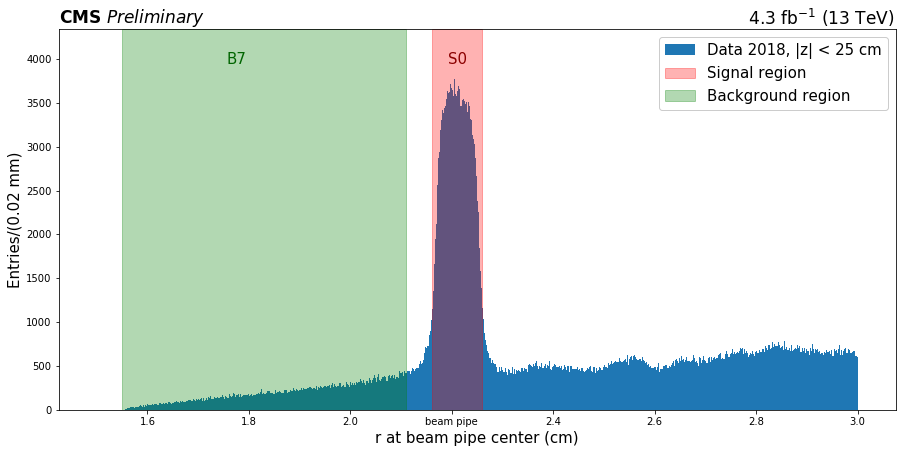

In [3]:
def makeBand(xStart, xWidth, px, bandColor):
    transperance = 0.3
    for p, lw in zip(xStart,xWidth):
        #plt.axvline(p, color=bandColor, alpha = transperance)
        lab = ""
        if bandColor == "green" and p == xStart[0]:
            lab = "Background region"
        elif bandColor =="red" and p == xStart[0]:
            lab = "Signal region"
        px.axvspan(p, p+lw, alpha = transperance, color=bandColor, label = lab)

def makeSBtext(xPos,yPos, px, text, textColor, fontS = 15):
    for i_xPos, i_text in zip(xPos,text):
        px.text(i_xPos, yPos, i_text,
                verticalalignment='bottom', horizontalalignment='left',
                transform=px.transAxes, color=textColor, fontsize=fontS)

# the histogram of the data
Radius, Radius_BP, Radius_BPIX, Radius_Tube = CalcRad(data[:,1], data[:,2])

# using the variable ax for single a Axes
fig, ax = plt.subplots(figsize=(15,7))
#num_bins = 180
num_bins = 750

#correction to beam pipe
Rmin, Rmax = 1.5, 3.
n, bins, patches = ax.hist(Radius_BP[np.logical_and(Radius_BP >Rmin, Radius_BP <Rmax)], num_bins,
                           range = [Rmin, Rmax],label=labelData)

ax.set_ylim(0., 1.15 * np.max(n))


#                BP      
xSignal_BP =    [2.16]
lw_Signal_BP =  [0.1]
makeBand(xSignal_BP, lw_Signal_BP, ax, "red")

#           before BP
xBkg_BP =   [1.55]
lw_Bkg_BP = [0.56]
makeBand(xBkg_BP, lw_Bkg_BP, ax, "green")


yBkgPos = 0.9
#background   befor BP
xBkgPos =    [0.2]
textPos =    ["B7"]
#plot backgrounds' titles:
makeSBtext(xBkgPos, yBkgPos, ax, textPos, "darkgreen")

ySPos = 0.90
#Signal    BP
xSPos =   [0.465]
textPos = ["S0"]
makeSBtext(xSPos, ySPos, ax, textPos, "darkred")

Xtitle = "r at beam pipe center"
ax.set_xlabel(Xtitle+' (cm)')
ax.set_ylabel('Entries/(%1.2f mm)'%(10*(bins[1]-bins[0]))) 

SetCMSlabel(ax)
ax.legend(loc="upper right",framealpha=1.)
a=ax.get_xticks().tolist()
a = np.round(a,2)
a = ["%.1f" % number for number in a]
a[4]='beam pipe'
ax.set_xticklabels(a,rotation=0)

if DataType == "Toy":
    plt.savefig('Results/Toy_R_atBeamPipe.pdf')
else:
    plt.savefig('Results/R_atBeamPipe.pdf')
plt.show()

* Classification for signal, S0, (red) and background, B7, (green) regions is done. 
* Background after beam pipe is not classified, because there is a contribution from smeared BPIX detector inner shield and layer 1. 
* Background-signal ratio (B/S) for beam pipe region is estimated from sidebands to be around 0.16. 

## Set Signal and Background regions for BPIX <a class="anchor" id="SetBPIX"></a>

[jump to top](#Top)

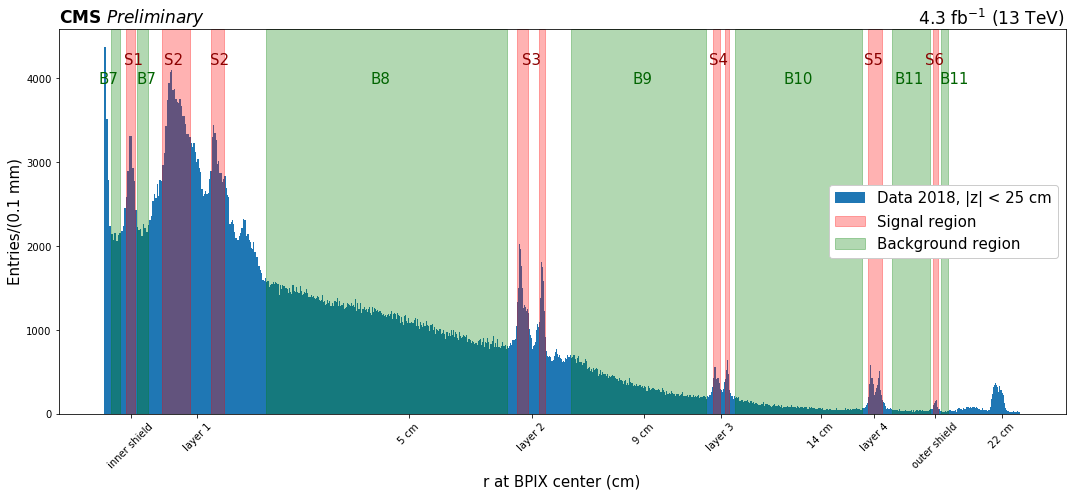

In [4]:
# using the variable ax for single a Axes
fig, ax = plt.subplots(figsize=(15,7))
num_bins = 2100

#correction to BPIX

Rmin, Rmax = 2.34, 23.
if DataType == "Toy":
    Rmin = 2.33
n, bins, patches = ax.hist(Radius_BPIX[np.logical_and(Radius_BPIX >Rmin, Radius_BPIX <Rmax)], 
                           num_bins, range = [Rmin, Rmax], label=labelData) # range force range without events

#          Inner Shield      L1_1    L1_2    L2_1  L2_2     L3_1   L3_2      L4_1_2 Outer Shield      
xSignal_BPIX = [2.47,        2.7,    3.05,   6.56, 6.93,    10.68, 11.01,    15.75, 18.53]
lw_Signal_BPIX =  [0.055,    0.2,    0.1,    0.17,  0.09,     0.2,  0.12,      0.55, 0.2]
#lw_Signal_BPIX =  [0.055,       0.2, 0.1,    0.1,  0.09,     0.2,  0.12,      0.55, 0.2]
makeBand(xSignal_BPIX, lw_Signal_BPIX, ax, "red")

#              BP-S    S-L1    L1-L2  L2-L3  L3-L4   L4-OS   OS-Rails
xBkg_BPIX =   [2.38,   2.54,   3.5,   7.5,   11.3,   16.7,   18.9]
lw_Bkg_BPIX = [0.05,   0.07,   2.9,   3.0,   4.2,    1.7,    0.3]
makeBand(xBkg_BPIX, lw_Bkg_BPIX, ax, "green")
            
yBkgPos = 0.85
#background   befor L1    L1-L2 L2-L3 L3-L4  L4-TIB1
xBkgPos =    [0.04, 0.077, 0.31, 0.57, 0.72,  0.83, 0.875]
textPos =    ["B7", "B7",  "B8", "B9", "B10", "B11", "B11"]
#plot backgrounds' titles:
makeSBtext(xBkgPos, yBkgPos, ax, textPos, "darkgreen")

ySPos = 0.9
#Signal    IS     L1           L2    L3     L4    OS
xSPos =   [0.065, 0.105, 0.15, 0.46, 0.646, 0.8,  0.86]
textPos = ["S1",  "S2",  "S2", "S3", "S4",  "S5", "S6"]
makeSBtext(xSPos, ySPos, ax, textPos, "darkred")

plt.xscale('log')
# plt.yscale('log')

# ax.set_xlim(Rmin,Rmax) # brake customize labels
Xtitle = "r at BPIX center"
ax.set_xlabel(Xtitle+' (cm)')
ax.set_ylabel('Entries/(%1.1f mm)'%(10*(bins[1]-bins[0]))) 

SetCMSlabel(ax)
ax.legend(loc="center right",framealpha=1.)
ax.tick_params(axis='x', which='minor', length=0) # remove minor ticks from 'log' scale
labBPIX =  ["inner shield", "layer 1", "5 cm", "layer 2", "9 cm", "layer 3", "14 cm", "layer 4", "outer shield", "22 cm"]
xlabBPIX = [2.5,             2.95,      5.0,    6.8,       9.0,    10.9,      14.0,    16.0,      18.6,           22.]
plt.xticks(xlabBPIX, labBPIX,rotation=45)
# funy staff for muliple labling: https://stackoverflow.com/questions/53043732/multiple-x-labels-on-pyplot
# Tweak spacing to prevent clipping of ylabel
fig.tight_layout() # force savefig save full plot, including x-label, important for customize xticks case

if DataType == "Toy":
    plt.savefig('Results/Toy_R_atBPIX.pdf')
else:
    plt.savefig('Results/R_atBPIX.pdf')
plt.show()


* Classification for signal, S1-S6, (red) and background, B7-B11, (green) regions is done. 
* Background-signal ratio (B/S) for all material elements in BPIX detector is estimated from sidebands to be around 2.6 for inner shield (S1), 1.2 for layer 1 (S2), 0.9 for layer 2 (S3), 0.7 for layer 3 (S4), 0.17 for layer 4 (S5), and 0.4 for outer shield (S6).

## Set Signal and Background regions for pixel support tube <a class="anchor" id="SetTube"></a>
[jump to top](#Top)

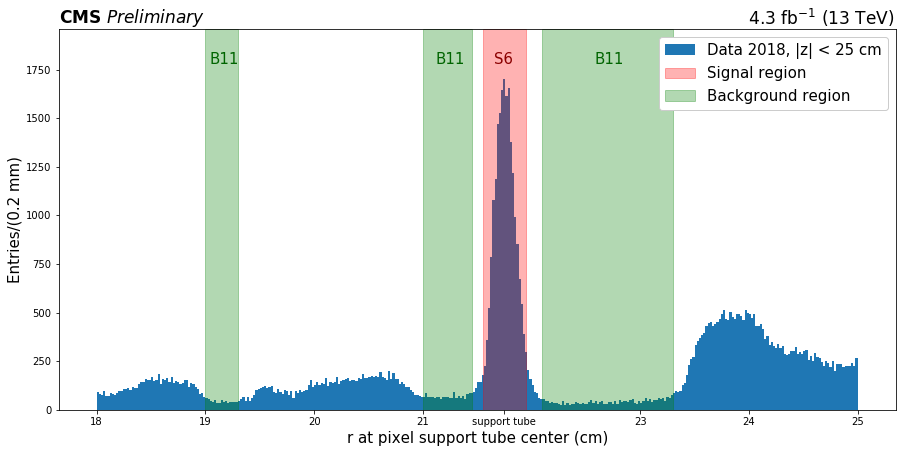

In [5]:
# using the variable ax for single a Axes
fig, ax = plt.subplots(figsize=(15,7))
num_bins = 350

#correction to pixel support tube
Rmin, Rmax = 18., 25.
n, bins, patches = ax.hist(Radius_Tube[np.logical_and(Radius_Tube > Rmin, Radius_Tube < Rmax)], num_bins,
                          range = [Rmin, Rmax],label=labelData)
ax.set_ylim(0., 1.15 * np.max(n))
#                  Tube     
xSignal_Tube   =  [21.55]
lw_Signal_Tube =  [0.4]
makeBand(xSignal_Tube, lw_Signal_Tube, ax, "red")

#             OS-Tube Rails-Tube Tube-TIB1
xBkg_Tube =   [19.,   21.,       22.1]
lw_Bkg_Tube = [0.3,   0.45,      1.2]
makeBand(xBkg_Tube, lw_Bkg_Tube, ax, "green")


#plt.xscale('log')
#plt.yscale('log')

yBkgPos = 0.9
#background   L4-TIB1
xBkgPos =    [0.18, 0.45, 0.64]
textPos =    ["B11", "B11", "B11"]
#plot backgrounds' titles:
makeSBtext(xBkgPos, yBkgPos, ax, textPos, "darkgreen")

ySPos = 0.9
#Signal    BPIX support tube
xSPos =   [0.52]
textPos = ["S6"]
makeSBtext(xSPos, ySPos, ax, textPos, "darkred")

Xtitle = "r at pixel support tube center"
ax.set_xlabel(Xtitle+' (cm)')
ax.set_ylabel('Entries/(%1.1f mm)'%(10*(bins[1]-bins[0]))) 

SetCMSlabel(ax)
ax.legend(loc="upper right",framealpha=1.)

a=ax.get_xticks().tolist()
a_pos = ax.xaxis.get_ticklocs().tolist()
logger.debug ("a_pos = " +str(a_pos))
a = np.round(a,2)
a = ["%.0f" % number for number in a]
a[5]='support tube'
a_pos[5] = 21.75
del a[-1]
del a_pos[-1]
del a[0]
del a_pos[0]
# ax.set_xticklabels(a,rotation=0)
plt.xticks(a_pos, a)

if DataType == "Toy":
    plt.savefig('Results/Toy_R_atTube.pdf')
else:
    plt.savefig('Results/R_atTube.pdf')
plt.show()

* Classification for signal, S6, (red) and background, B11, (green) regions is done. 
* Background-signal ratio (B/S) for the support tube is estimated from sidebands to be around 0.06 (S6).

## Set Signal and Background regions  for rails, by using  x position of NI candidate <a class="anchor" id="SetRails"></a>
[jump to top](#Top)

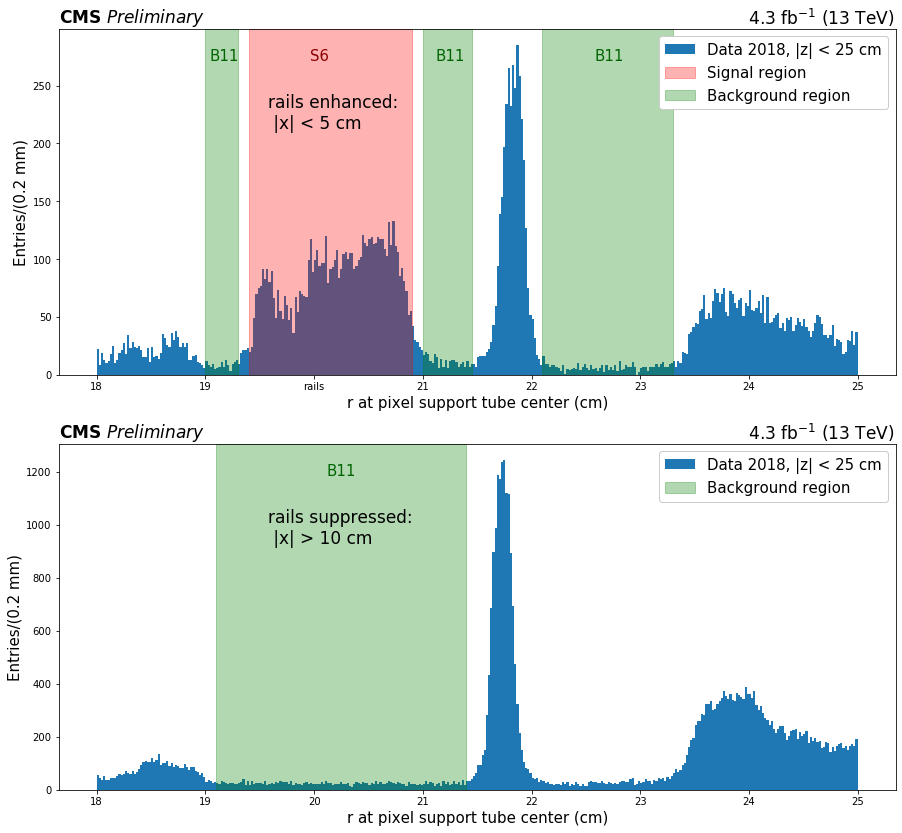

In [6]:
# using the variable ax for single a Axes
fig, (ax,bx) = plt.subplots(2,1, figsize=(15,14))
num_bins = 350

#correction to pixel support tube
Rmin, Rmax = 18., 25.
n, bins, patches = ax.hist(Radius_Tube[np.logical_and(np.logical_and(Radius_Tube >Rmin, Radius_Tube <Rmax), 
                                                      np.logical_and(data[:,1]> -5, data[:,1]<5))], num_bins,
                          range = [Rmin, Rmax],label=labelData)
n_b, bins_b, patches_b = bx.hist(Radius_Tube[np.logical_and(np.logical_and(Radius_Tube >Rmin, Radius_Tube <Rmax), 
                                                            np.logical_or(data[:,1]< -10, data[:,1]>10))], num_bins,
                                range = [Rmin, Rmax],label=labelData)
Xtitle = "r at pixel support tube center"

#                  Rails     
xSignal_Rails   =  [19.4]
lw_Signal_Rails =  [1.5]
makeBand(xSignal_Rails, lw_Signal_Rails, ax, "red")

# the same background as for pixel support tube:
makeBand(xBkg_Tube, lw_Bkg_Tube, ax, "green")

#                 noRails region: |PFDV_X| > 10 cm, PFDV_X = data[:,1]
xBkg_noRails =   [19.1]
lw_Bkg_noRails = [2.3]
makeBand(xBkg_noRails, lw_Bkg_noRails, bx, "green")

yBkgPos = 0.9
#background   L4-TIB1
xBkgPos =    [0.18, 0.45, 0.64]
textPos =    ["B11", "B11", "B11"]
#plot backgrounds' titles:
makeSBtext(xBkgPos, yBkgPos, ax, textPos, "darkgreen")

ySPos = 0.9
#Signal    BPIX rails
xSPos =   [0.3]
textPos = ["S6"]
makeSBtext(xSPos, ySPos, ax, textPos, "darkred")

yBkgPos = 0.9
#background   L4-TIB1
xBkgPos =    [0.32]
textPos =    ["B11"]
#plot backgrounds' titles:
makeSBtext(xBkgPos, yBkgPos, bx, textPos, "darkgreen")

Xtitle = "r at pixel support tube center"
ax.set_xlabel(Xtitle+' (cm)')
ax.set_ylabel('Entries/(%1.1f mm)'%(10*(bins[1]-bins[0]))) 
bx.set_xlabel(Xtitle+' (cm)')
bx.set_ylabel('Entries/(%1.1f mm)'%(10*(bins[1]-bins[0])))

SetCMSlabel(ax)
SetCMSlabel(bx)
ax.legend(loc="upper right",framealpha=1.)
bx.legend(loc="upper right",framealpha=1.)
ax.text(0.25,0.7,"rails enhanced:\n |x| < 5 cm", size = 17, transform=ax.transAxes,
        verticalalignment='bottom', horizontalalignment='left')
bx.text(0.25,0.7,"rails suppressed:\n |x| > 10 cm", size = 17, transform=bx.transAxes,
        verticalalignment='bottom', horizontalalignment='left')

a=ax.get_xticks().tolist()
a = np.round(a,2)
a = ["%.0f" % number for number in a]
a[3]='rails'
logger.debug("a = " +str(a))
ax.set_xticklabels(a,rotation=0)
#ax.set_xticks(a_pos, a)

if DataType == "Toy":
    plt.savefig('Results/Toy_R_atTube_forRails.pdf')
else:
    plt.savefig('Results/R_atTube_forRails.pdf')
plt.show()

* Top plot corresponds to the enhanced region for the BPIX detector rails (|𝑥| <  5 cm , where 𝑥 is the 𝑥 coordinate of the vertex), while bottom plot corresponds to the suppressed region for the rails (|𝑥| > 10 cm ).
* Classification for signal, S6, (red) and background, B11, (green) regions is done. Background-signal ratio (B/S) for the BPIX detector rails is estimated from sidebands to be around 0.13 (S6).

## Classify NI candidates as Signal, as Background, and as Non-classified regions <a class="anchor" id="ClassifyEvents"></a>
[jump to top](#Top)

Pre-classification for NN is done:
* 0-6 for signal regions,
* 7-11 for background regions,
* -1 for non-classified regions.

In [7]:
def SetYval(xStart, xWidth, Yval, Rad):    
    for p, lw, yVal in zip(xStart, xWidth, Yval):
        logicVal = np.logical_and(Rad > p, Rad < (p+lw))
        Y[logicVal] = yVal

def SetYvalRails(xStart, xWidth, Yval, Rad):
    for p, lw, yVal in zip(xStart, xWidth, Yval):
        logicVal = np.logical_and(np.logical_and(Rad > p, Rad < (p+lw)),
                                  np.logical_and(data[:,1] > -5, data[:,1] < 5))
        # assinge yVal only if logicVal
        Y[logicVal] = yVal        
def SetYvalnoRails(xStart, xWidth, Yval, Rad):
    for p, lw, yVal in zip(xStart, xWidth, Yval):
        logicVal = np.logical_and(np.logical_and(Rad > p, Rad < (p+lw)),
                                  np.logical_or(data[:,1] < -10, data[:,1] > 10))
        # assinge yVal only if logicVal
        Y[logicVal] = yVal 
        
logger.info ("data shape = "+str(data.shape))
Y = np.zeros((data.shape[0])) - 1
logger.info ("shape of Y = " +str(Y.shape))

#Define values for Y: 0-6 - Signal, 7-11 - Background:

#          Inner Shield L1_1 L1_2    L2_1  L2_2     L3_1   L3_2      L4_1_2 Outer Shield 
Y_Signal_BPIX = [1,     2,   2,      3,    3,       4,     4,        5,     6]
logger.debug("Signal       BPIX = " + str(xSignal_BPIX))
logger.debug("Signal width BPIX = " + str(lw_Signal_BPIX))
#              BP-S    S-L1    L1-L2  L2-L3  L3-L4   L4-OS   OS-Rails
Y_Bkg_BPIX =   [7,     7,      8,     9,     10,     11,     11]
logger.debug("Bkg          BPIX = " + str(xBkg_BPIX))
logger.debug("BKg    width BPIX = " + str(lw_Bkg_BPIX))

Y_Signal_BP = [0]
logger.debug("Signal       BP = " + str(xSignal_BP))
logger.debug("Signal width BP = " + str(lw_Signal_BP))
Y_Bkg_BP = [7]
logger.debug("Bkg          BP = " + str(xBkg_BP))
logger.debug("Bkg    width BP = " + str(lw_Bkg_BP))

# Tube
Y_Signal_Tube = [6]
logger.debug("Signal       Tube = " + str(xSignal_Tube))
logger.debug("Signal width Tube = " + str(lw_Signal_Tube))
#             OS-Tube Rails-Tube Tube-TIB1
Y_Bkg_Tube = [11, 11, 11]
logger.debug("Bkg          Tube = " + str(xBkg_Tube))
logger.debug("Bkg    width Tube = " + str(lw_Bkg_Tube))

# Special case for Rails with cut on PFDV_X
#                 Rails region: |PFDV_X| < 5 cm, PFDV_X = data[:,1]
#                 the same background as for Tube
Y_Signal_Rails = [6]
logger.debug("Signal       Rails = " + str(xSignal_Rails))
logger.debug("Signal width Rails = " + str(lw_Signal_Rails))
#                 noRails region: |PFDV_X| > 10 cm, PFDV_X = data[:,1]
#             OS-Tube
Y_Bkg_noRails = [11]
logger.debug("Bkg          noRails = " + str(xBkg_noRails))
logger.debug("Bkg    width noRails = " + str(lw_Bkg_noRails))

# Set up values for Y: start with Singnal, finish with Background

SetYval(xSignal_BPIX, lw_Signal_BPIX, Y_Signal_BPIX, Radius_BPIX)
SetYval(xBkg_BPIX, lw_Bkg_BPIX, Y_Bkg_BPIX, Radius_BPIX)
SetYval(xSignal_BP, lw_Signal_BP, Y_Signal_BP, Radius_BP)
SetYval(xBkg_BP, lw_Bkg_BP, Y_Bkg_BP, Radius_BP)
SetYval(xSignal_Tube, lw_Signal_Tube, Y_Signal_Tube, Radius_Tube)
SetYval(xBkg_Tube, lw_Bkg_Tube, Y_Bkg_Tube, Radius_Tube)
SetYvalRails(xSignal_Rails, lw_Signal_Rails, Y_Signal_Rails, Radius_Tube)
SetYvalnoRails(xBkg_noRails, lw_Bkg_noRails, Y_Bkg_noRails, Radius_Tube)

logger.debug ("count (Y >= 0) = %d " % (np.count_nonzero(Y >= 0)))
for i in range(-1,12):
    logger.debug ("count (Y = %d) = %d " % (i, np.count_nonzero(Y == i)))

INFO:log:data shape = (1397381, 27)
INFO:log:shape of Y = (1397381,)


## Check classification result <a class="anchor" id="CheckClassification"></a>

In this section, you could check signal region classification for all structures but beam pipe.

[jump to top](#Top)

In [ ]:
# using the variable ax for single a Axes
fig, ax = plt.subplots(figsize=(15,7))
num_bins = 2000

#correction to BPIX
#Signal
n, bins, patches = ax.hist(Radius_BPIX[np.logical_and(np.logical_and(Radius_BPIX >2.33, Radius_BPIX <23),
                                                      np.logical_and(Y > 0, Y < 7))], num_bins)

#n, bins, patches = ax.hist(Radius_BPIX[np.logical_and(Radius_BPIX >2.4, Radius_BPIX <18)], num_bins)
Xtitle = "r at BPIX center"


ax.set_xlabel(Xtitle+', cm')
ax.set_ylabel('Entries')
ax.set_title(Xtitle+' for |z| < 25 cm for signal cut test')

if DataType == "Toy":
    plt.savefig('Results/Toy_R_atBPIX_testSignalCuts.pdf')
else:
    plt.savefig('Results/R_atBPIX_testSignalCuts.pdf')
    
plt.show()

## Estimate background-signal ratio (B/S) of each signal region<a class="anchor" id="BkgEstimation"></a>
[jump to top](#Top)

* Estimation of the background, $B_{underS}$, and signal, $S_{underS}$, under signal region is done by sideband technique:

$B_{underS}(w) = B_{before}(w/2) + B_{after}(w/2) $, where w is the width of the signal region, $B_{before}$ and $B_{after}$ are taken from neighbor background regions, respectively. 

$S_{underS} = All_{underS} - B_{underS}$, where $All_{underS}$ is the total number of the NI candidates in the signal region. 

* B/S ratio under each signal region is done:

B/S ratio $= B_{underS}/S_{underS}$ 

* Signal weight for cross entropy is estimated: 

$w_{Signal} = B_{estimated}/S_{estimated} $, 

where

$S_{estimated} = \Sigma_{\text {signal region}} S_{underS}$ 
and $B_{estimated} = \Sigma_{\text {signal region}} B_{underS} + \Sigma_{\text {background region}} B_{underB}$  

Attention: 
* For beam pipe, $B_{after}$ is started at $R_{BP}$ = 2.3 cm. It is true that we have smeared signals from inner shield and layer 1, but their contributions are much smaller than combinatorial background. 
* For layer 1, $B_{before}$ has width less then $w/2$, that its why $B_{before}$ in this region was calculated, using width of the background band, $w_b$ and scaled to $w/2$: $scale = (w/2)/w_b$

In [9]:
# Background under beam pipe

def BtoS_BP(Rad):
    ratio = 0.
    # width BP
    width_S = lw_Signal_BP[0]
    S_left = xSignal_BP[0]
    
    # backgound before beam pipe is finished
    B_left = xBkg_BP[0] + lw_Bkg_BP[0]
    # beckground after beam pipe is start
    B_right = 2.3
    # count backgound 
    B_underS = np.count_nonzero(np.logical_and(Rad > (B_left - width_S/2),Rad < B_left)) + np.count_nonzero(np.logical_and(Rad > B_right,Rad < (B_right + width_S/2)))
    SandB_udnerS = np.count_nonzero(np.logical_and(Rad > (S_left),Rad < (S_left+width_S)))
    S_underS = SandB_udnerS - B_underS
    epsilon = 1.0e-6
    ratio = B_underS/(S_underS + epsilon)
    return ratio, S_underS, B_underS


# Background under BPIX (IS, L1-L4, OS)

def BtoS_BPIX(Rad,Name = "L1"):
    ratio = 0.
    if Name == "IS":
        iS = 0
        iS2 = 0 # don't use iS2 if for IS
        iB_left = 0
        iB_right = 1
    elif Name == "L1":
        iS = 1
        iS2 = 2
        iB_left = 1
        iB_right = 2
    elif Name == "L2":
        iS = 3
        iS2 = 4
        iB_left = 2
        iB_right = 3
    elif Name == "L3":
        iS = 5
        iS2 = 6
        iB_left = 3
        iB_right = 4
    elif Name == "L4":
        iS = 7
        iS2 = 7 # don't use iS2 if for L4
        iB_left = 4
        iB_right = 5
    elif Name == "OS":
        iS = 8
        iS2 = 8 # don't use iS2 if for L4
        iB_left = 5
        iB_right = 6
    else:
        print("Error in BtoS_BPIX: Name structure is not correct")
    
    width_S = lw_Signal_BPIX[iS]
    S_left  = xSignal_BPIX[iS]
    width_S2 = lw_Signal_BPIX[iS2]
    S2_left  = xSignal_BPIX[iS2]
    # backgound before structure is finished
    B_left = xBkg_BPIX[iB_left] + lw_Bkg_BPIX[iB_left]
    # beckground after structure is start
    B_right = xBkg_BPIX[iB_right]
    # count backgound
    if Name == "IS" or Name == "L4" or Name == "OS": # one signal region
        B_underS = np.count_nonzero(np.logical_and(Rad > (B_left - width_S/2),Rad < B_left)) + np.count_nonzero(np.logical_and(Rad > B_right,Rad < (B_right + width_S/2)))
        SandB_udnerS = np.count_nonzero(np.logical_and(Rad > (S_left),Rad < (S_left+width_S)))
    elif Name == "L1": # 2 signal regions with narrow backgound at left
        Bwidth_left = lw_Bkg_BPIX[iB_left]
        # scale left nerrow backgound slice to (width_S+width_S2)
        Scale_left = (width_S+width_S2)/2/Bwidth_left
#         print("Type of Scale_left = " + str(type(Scale_left)))
        B_underS = np.count_nonzero(np.logical_and(Rad > (B_left - Bwidth_left),Rad < B_left))
        B_underS = Scale_left*B_underS 
        B_underS = B_underS + np.count_nonzero(np.logical_and(Rad > B_right,Rad < (B_right + (width_S+width_S2)/2)))
        SandB_udnerS = np.count_nonzero(np.logical_and(Rad > (S_left),Rad < (S_left+width_S)))
        SandB_udnerS = SandB_udnerS + np.count_nonzero(np.logical_and(Rad > (S2_left),Rad < (S2_left+width_S2)))
        
    elif Name == "L2" or Name == "L3": # 2 signal regions
        B_underS = np.count_nonzero(np.logical_and(Rad > (B_left - (width_S+width_S2)/2),Rad < B_left))
        B_underS = B_underS + np.count_nonzero(np.logical_and(Rad > B_right,Rad < (B_right + (width_S+width_S2)/2)))
        SandB_udnerS = np.count_nonzero(np.logical_and(Rad > (S_left),Rad < (S_left+width_S)))
        SandB_udnerS = SandB_udnerS + np.count_nonzero(np.logical_and(Rad > (S2_left),Rad < (S2_left+width_S2)))
        
    S_underS = SandB_udnerS - B_underS
    epsilon = 1.0e-6
    ratio = B_underS/(S_underS + epsilon)
    return ratio, S_underS, B_underS

# Backgorund under Tube 
def BtoS_Tube(Rad):
    ratio = 0.
    # width BP
    width_S = lw_Signal_Tube[0]
    S_left = xSignal_Tube[0]
    
    # backgound before beam pipe is finished
    B_left = xBkg_Tube[1] + lw_Bkg_Tube[1]
    # beckground after beam pipe is start
    B_right = xBkg_Tube[2]
    # count backgound 
    B_underS = np.count_nonzero(np.logical_and(Rad > (B_left - width_S/2),Rad < B_left)) + np.count_nonzero(np.logical_and(Rad > B_right,Rad < (B_right + width_S/2)))
    SandB_udnerS = np.count_nonzero(np.logical_and(Rad > (S_left),Rad < (S_left+width_S)))

    S_underS = SandB_udnerS - B_underS
    epsilon = 1.0e-6
    ratio = B_underS/(S_underS+epsilon)
    return ratio, S_underS, B_underS  

# Backgorund under Rails 
def BtoS_Rails(Rad, X_Rails):
    ratio = 0.
    # width BP
    width_S = lw_Signal_Rails[0]
    S_left = xSignal_Rails[0]
    
    # backgound before beam pipe is finished
    B_left = xBkg_Tube[0] + lw_Bkg_Tube[0] # the same bkg as for Tube
    Bwidth_left = lw_Bkg_Tube[0]
    # scale left nerrow backgound slice to width_S
    Scale_left = width_S/2/Bwidth_left
    # beckground after beam pipe is start
    B_right = xBkg_Tube[1]
    Bwidth_right = lw_Bkg_Tube[1]
    # scale left nerrow backgound slice to width_S
    Scale_right = width_S/2/Bwidth_right
        
    # count backgound 
    B_underS = Scale_left* np.count_nonzero(np.logical_and(np.abs(X_Rails) < 5, 
                                                           np.logical_and(Rad > (B_left - Bwidth_left),Rad < B_left)))
    B_underS = B_underS + Scale_right*np.count_nonzero(np.logical_and(np.abs(X_Rails) < 5, 
                                                                      np.logical_and(Rad > B_right,Rad < (B_right + Bwidth_right))))
    SandB_udnerS = np.count_nonzero(np.logical_and(np.abs(X_Rails) < 5, np.logical_and(Rad > (S_left), Rad < (S_left+width_S))))

    S_underS = SandB_udnerS - B_underS
    epsilon = 1.0e-6
    ratio = B_underS/(S_underS + epsilon)
    return ratio, S_underS, B_underS

# Backgorund under Background  
def BtoS_Bkg(Rad_BP, Rad_BPIX, Rad_Tube):
    ratio = 1000. # there is not signal at background region
        
    # count backgound before BP:
    Bx = xBkg_BP[0]
    Bwidth = lw_Bkg_BP[0] 
    B_underB = np.count_nonzero(np.logical_and(Rad_BP > Bx,Rad_BP < (Bx + Bwidth)))
    
    for Bx, Bwidth in zip(xBkg_BPIX, lw_Bkg_BPIX):
        B_underB = B_underB + np.count_nonzero(np.logical_and(Rad_BPIX > Bx,Rad_BPIX < (Bx + Bwidth)))
    for Bx, Bwidth in zip(xBkg_Tube, lw_Bkg_Tube):
        B_underB = B_underB + np.count_nonzero(np.logical_and(Rad_Tube > Bx,Rad_Tube < (Bx + Bwidth)))

    S_underB = 0.
    return ratio, S_underB, B_underB

# for NN injections:
MaterialOfInterest_NN = ["BP", "L2", "L3", "L4", "Tube", "Rails", "Background"]
# for NN injections without background:
MaterialOfInterest_NN_noBkg = ["BP", "L2", "L3", "L4", "Tube", "Rails"]
# for all structures:
MaterialOfInterest_All = ["BP", "IS","L1","L2", "L3", "L4","OS", "Tube", "Rails", "Background"]
# Pixel material:
MaterialOfPixel =    ["IS","L1", "L2", "L3", "L4", "OS"]

def PreReF1(Rad_BP, Rad_BPIX, Rad_Tube, X_Rails, Mat, Mat_Pixel):    

    prec_Mat, recall_Mat, f1_Mat= 0., 0., 0.
    tp, tn, fp, fn = 0., 0., 0., 0.
    
    lenth = np.size(Mat)
    S_estimate = np.zeros(lenth)
    B_estimate = np.zeros(lenth)
    ratio_estimate = np.zeros(lenth)

    for i in range(0,lenth):
        if Mat[i] == "BP":
            ratio_estimate[i], S_estimate[i], B_estimate[i] = BtoS_BP(Rad_BP)
            fp = fp + B_estimate[i]
        if any(Mat[i] == x for x in Mat_Pixel):
            ratio_estimate[i], S_estimate[i], B_estimate[i] = BtoS_BPIX(Rad_BPIX, Mat[i])
            fp = fp + B_estimate[i]
        elif Mat[i] == "Tube":
            ratio_estimate[i], S_estimate[i], B_estimate[i] = BtoS_Tube(Rad_Tube)
            fp = fp + B_estimate[i]
        elif Mat[i] == "Rails":
            ratio_estimate[i], S_estimate[i], B_estimate[i] = BtoS_Rails(Rad_Tube, X_Rails)
            fp = fp + B_estimate[i]
        elif Mat[i] == "Background":
            ratio_estimate[i], S_estimate[i], B_estimate[i] = BtoS_Bkg(Rad_BP, Rad_BPIX, Rad_Tube)
            tn = tn + B_estimate[i]

    # calculated f1score
    tp = np.sum(S_estimate)
    fn = 0.
    epsilon = 1.0e-6
    B_est_tot = np.sum(B_estimate)
    w_Signal = B_est_tot/(tp+epsilon)

    prec_Mat = tp / (tp + fp + epsilon)
    recall_Mat = tp / (tp + fn + epsilon)

    f1_Mat = 2*prec_Mat*recall_Mat / (prec_Mat+recall_Mat+epsilon)

    return ratio_estimate, S_estimate, B_estimate, prec_Mat, recall_Mat, f1_Mat, w_Signal

ratio_est, S_est, B_est, prec_NN, recall_NN, f1Score_NNinjected, wSignal_NN = PreReF1(Radius_BP, Radius_BPIX, 
                                                                                      Radius_Tube, data[:,1], 
                                                                                      MaterialOfInterest_NN, 
                                                                                      MaterialOfPixel)[0:7]

# wSignal_NN = PreReF1(Radius_BP, Radius_BPIX, Radius_Tube, data[:,1], MaterialOfInterest_NN, MaterialOfPixel)[6]

lenth = np.size(B_est)

for i in range(0,lenth):
    logger.debug("Ratio(B/S) at %s = %4.2f, signal = %7.0f, and background = %7.0f" % 
                (MaterialOfInterest_NN[i],ratio_est[i], S_est[i], B_est[i]))
        
logger.debug(" Selected material: precison = %3.3f, recall =  %3.2f, f1 score =  %3.2f" % 
            (prec_NN, recall_NN, f1Score_NNinjected))

logger.debug("f1Score_NNinjected = " + str(f1Score_NNinjected))
logger.info("Recommended signal weight for NN = " + str(round(wSignal_NN,2)))


from IPython.display import HTML, display

def display_table(dataIn):
    html = "<table>"
    for row in dataIn:
        html += "<tr>"
        for field in row:
            html += "<td><h4>%s</h4><td>"%(field)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))

ratioAll_est = PreReF1(Radius_BP, Radius_BPIX, Radius_Tube, data[:,1],MaterialOfInterest_All, MaterialOfPixel)[0:1]

lenthAll = np.size(ratioAll_est)
extra = ["B/S ratio"]
MaterialOfInterest_All_table = np.r_[np.reshape(extra,(1,)), np.reshape(MaterialOfInterest_All,(lenthAll,))]
logger.debug("shape of MaterialOfInterest_All_table = " + str(np.shape(MaterialOfInterest_All_table)))
extra = ["no classification"]
ratio_estAll_table = np.r_[np.reshape(extra,(1,)),np.reshape(np.round(ratioAll_est,2),(lenthAll,))]

# display_table([MaterialOfInterest_All, np.round(ratio_est,2)])
display_table([MaterialOfInterest_All_table, ratio_estAll_table])


INFO:log:Recommended signal weight for NN = 3.04


## Shuffle Data <a class="anchor" id="DataShufle"></a>
[jump to top](#Top)

Shuffle data ($X\_\text{NN}\_\text{orig}$) and $Y_{true}$ classification ($Y\_\text{NN}$) to avoid run(time)-dependent correlations.

Attention: 
* Before shuffling random seed was fixed to result in the same splitting for Train and Test sets each time running the code. This way, if we know on which data set (Train set) our model was trained, and we could use it again after re-uploading data.
 

In [10]:
#X_NN = data[:,4:27] # it will be set later, because we need to know R for Test set to plot it...
X_NN_orig = data

# set rendom seed to avoid different spitting for Train and Test sets each time
np.random.seed(1)
perm = np.random.permutation(X_NN_orig.shape[0])
logger.info("shape of perm = " + str(perm.shape))
logger.debug("perm = " + str(perm[1:100]))

# permutate X_NN_orig and Y: remove bias, when some parts of detector where not working for exampe...
X_NN_orig = X_NN_orig[perm]
Y_NN    = Y[perm]

INFO:log:shape of perm = (1397381,)


## Sort track variables by $p_T$ and normalize $p_T$ tracks <a class="anchor" id="SortPt"></a>
[jump to top](#Top)

21 of the 23 variables injected into the NN describe track qualities:
  * 3 tracks for each NI candidate:
    * $p_T$, $\eta$, and $\phi$;
    * $\chi^2$, and normalized $\chi^2$;
    * number of valid hits;
    * track reconstruction algorithm.
These variables were sorted by track transverse momentum, $p_T$, decreasing. $p_T$ of the leading track, $p_T^{leading}$ stays unchanged, but other 2 tracks were scaled to the $p_T^{leading}$: $p_T^{other}/p_T^{leading}$.

It could help for the NN training, because the ratio $p_T^{other}/p_T^{leading}$ could be more sensitive to internal NI structure then original $p_T$.

In [11]:
TrackNorm = True # sorting by pT decreasing and normalize subleading pT tracks
#TrackNorm = False # no sorting, no scaling

# Create index fore each trackers' parameter:
#                      pT eta phi chi2 normalizedChi2 numberOfValidHits algorithm
IndexTrk = np.array([6, 9,  12, 15,  18,            21,               24])

numTrk = 3 # 3 tracks per vertex
IndexNI = 6 # start from pT of tracks

Xpt = X_NN_orig[:, IndexNI:(IndexNI+numTrk)]

logger.debug("Xpt befor sort shape = " +str(Xpt.shape))
logger.debug("Xpt befor sort = " +str(Xpt[1:10,:]))

# sorting by decreasing (1st element is max,....)
argSortXpt = np.argsort(-Xpt, axis=1)
Xpt = np.array(list(map(lambda x, y: y[x], argSortXpt, Xpt)))

# Keep max pt track (1st track) and other tracks scale to it
Xpt[:,1:] = Xpt[:,1:]/Xpt[:,0].reshape(Xpt[:,0].size,1)

logger.debug("Xpt after sort = " +str(Xpt[1:10,:]))
logger.debug("argsort of Xpt = " +str(argSortXpt[1:10,:]))

# other parameters of tracks should be sorted the same way as pt (like eta, phi, chi2...)
Xtrk_other = np.array([])

for i_par in range(1,7):
    Xtrk = X_NN_orig[:,(IndexNI+numTrk*i_par) : (IndexNI+numTrk*(i_par+1))]
    Xtrk = np.array(list(map(lambda x, y: y[x], argSortXpt, Xtrk)))
    if i_par == 1 : # check if matrix is empty 
        Xtrk_other = Xtrk
    else:
        Xtrk_other = np.c_[Xtrk_other,Xtrk]

logger.debug("X_NN_orig before sort = " +str(X_NN_orig[1:10,9:]))
logger.debug("Xtrk_other after sort = " +str(Xtrk_other[1:10,:]))  

Xvertex = np.c_[Xpt,Xtrk_other]
if TrackNorm == True:
    X_NN = X_NN_orig
    X_NN[:, IndexNI:] = Xvertex
    logger.debug("X_NN after norm pT = " +str(X_NN[1:10,6:]))

## Plot variables, injected to NN <a class="anchor" id="VariablesToNN"></a>
[jump to top](#Top)

Select signal region of interest and plot variables, injected to NN.

In [12]:
import ipywidgets as widgets

d = widgets.Dropdown(options=['beam pipe', 'BPIX layer 1', 'BPIX layer 2', 'BPIX layer 3', 'BPIX layer 4', 'Tube/Rails'], value='beam pipe')
d


Dropdown(options=('beam pipe', 'BPIX layer 1', 'BPIX layer 2', 'BPIX layer 3', 'BPIX layer 4', 'Tube/Rails'), …

In [13]:
# Default is beam pipe region:
ys = 0 # BP
yb = 8 # background after BP & layer 1

if d.value == 'BPIX layer 1':
    ys = 2 # l1
    yb = 8
elif d.value == 'BPIX layer 2':
    ys = 3 # l2
    yb = 9
elif d.value == 'BPIX layer 3':
    ys = 4 # l3
    yb = 10
elif d.value == 'BPIX layer 4':
    ys = 5 # l4
    yb = 11 
elif d.value == 'Tube/Rails':
    ys = 6 # Tube and Raisl
    yb = 11 

logger.info("Region = " + str(d.value) + " is selected -> ys = " + str(ys) + " and yb = " + str(yb))

INFO:log:Region = beam pipe is selected -> ys = 0 and yb = 8


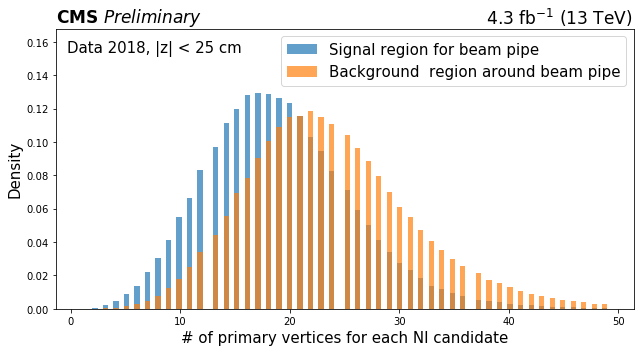

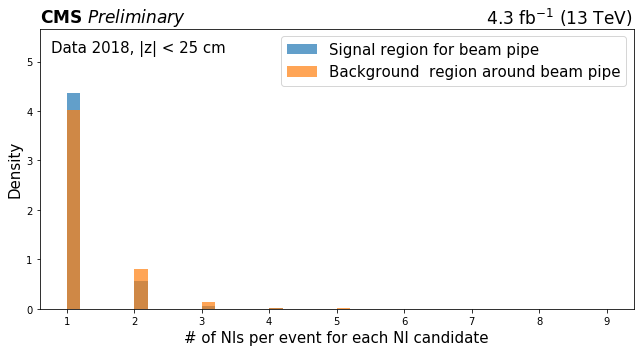

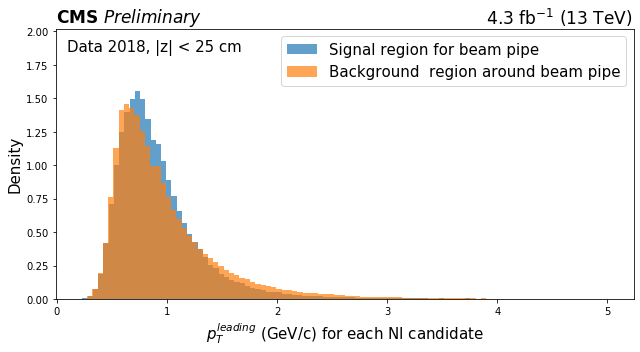

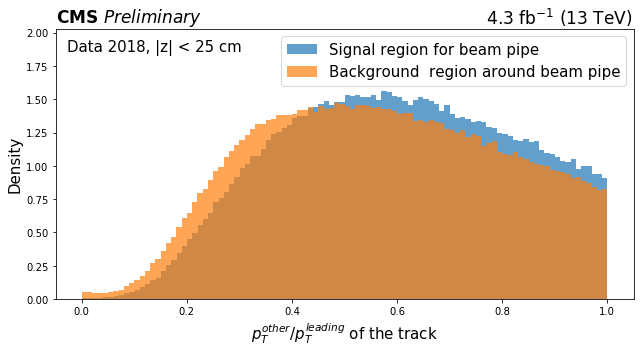

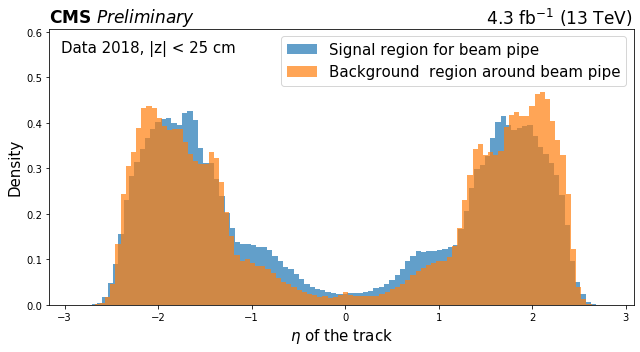

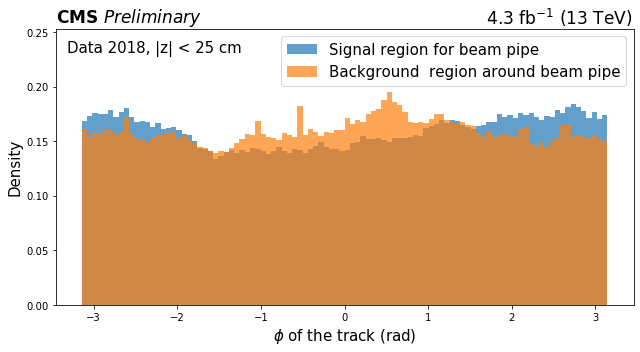

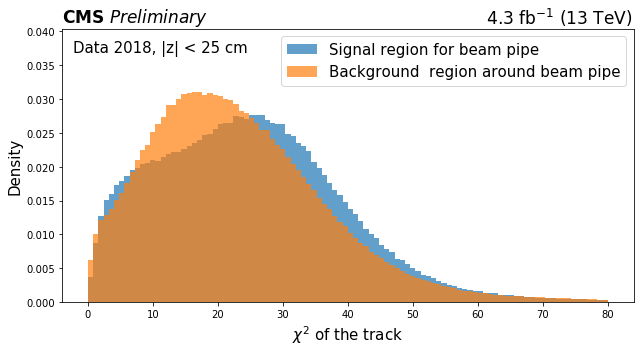

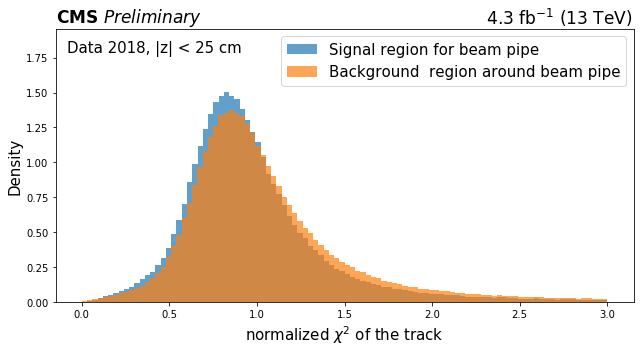

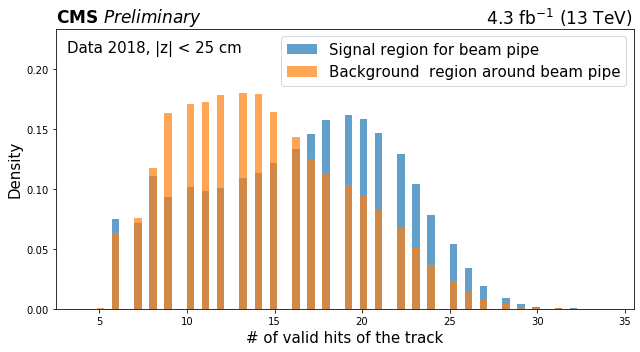

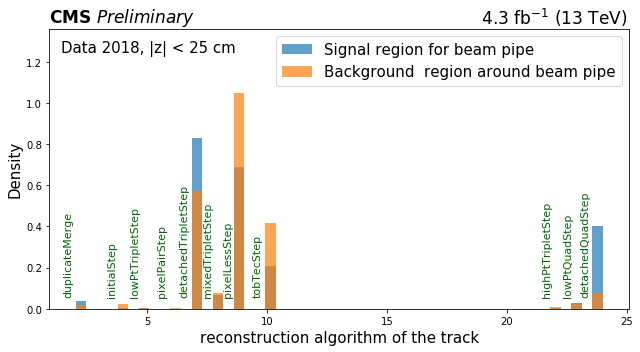

In [14]:
def PlotSvsBkg(index_var, varName, picName, num_bins, xmin, xmax, Y_S, Y_B, numPar, locPos = 'upper right'):
    fig, ax = plt.subplots(figsize=(9,5))

    XFill = X_NN[:, index_var]
    YFill = Y_NN
    # Fill (n >1) parameters Track 1, ... numPar
    if numPar > 1:
        for i_var in range(1,numPar):
            XFill = np.concatenate(([XFill,X_NN[:, index_var+i_var]]),axis=0)
            YFill =  np.concatenate(([YFill,Y_NN]),axis=0)

    flagSigma = "\Sigma" in varName
    if numPar == 2 and flagSigma: # it will work only for \Sigma pT and only there nunPar = 2
        XFill = X_NN[:, index_var] +X_NN[:, index_var+1]
        YFill = Y_NN 

    #Signal
    nS, binsS, patches = ax.hist(XFill[np.logical_and(YFill == Y_S,XFill < xmax)], 
                               num_bins, density = True, alpha = 0.7)
    n, bins, patches = ax.hist(XFill[np.logical_and(YFill == Y_B,XFill < xmax)], 
                               num_bins, density = True, alpha = 0.7)
    ax.set_ylim(0., 1.3 * max(np.max(nS),np.max(n)))

    if numPar == 3 or "other" in varName:
        Xtitle = varName + " of the track"
        if varName == "$\phi$": Xtitle = Xtitle + " (rad)" 
    else:
        Xtitle = varName + " for each NI candidate"
    
    ax.set_xlabel(Xtitle)
    ax.set_ylabel('Density')
    if Y_S == 0 and Y_B == 8:
        ax.legend(['Signal region for beam pipe', 'Background  region around beam pipe'], loc=locPos)
    elif Y_S == 5 and Y_B == 11:
        ax.legend(['Signal region for layer 4', 'Background region after layer 4'], loc=locPos)
    elif Y_S == 2 :
        ax.legend(['Signal region for layer 1', 'Background region after layer 1'], loc=locPos)
    elif Y_S == 3 :
        ax.legend(['Signal region for layer 2', 'Background region after layer 2'], loc=locPos)
    elif Y_S == 4 :
        ax.legend(['Signal region for layer 3', 'Background region after layer 3'], loc=locPos)
    elif Y_S == 6 :
        ax.legend(['Signal region for Tube and Rails', 'Background around Tube and Rails'], loc=locPos)
    else:
        ax.legend(['Signal', 'Background'], loc=locPos)

    ax.text(0.02,0.9,labelData, size = 15, transform=ax.transAxes,
            verticalalignment='bottom', horizontalalignment='left')
    if d.value == "beam pipe" or DataType == "Toy":
        SetCMSlabel(ax)
    else:
        SetCMSlabel(ax,"internal")

    # https://github.com/cms-sw/cmssw/blob/master/DataFormats/TrackReco/interface/TrackBase.h
    AlgoName   = ['duplicateMerge', 'initialStep',  'lowPtTripletStep', 'pixelPairStep', 'detachedTripletStep',
                 'mixedTripletStep', 'pixelLessStep', 'tobTecStep', 'highPtTripletStep', 'lowPtQuadStep', 'detachedQuadStep']
    AlgoNumber = [2,                 4,              5,                  6,               7,
                  8,                  9,               10,           22,                  23,              24]
    AlgoPosX   = [0.025,             0.1,            0.14,              0.185,             0.225,
                  0.265,                0.30,             0.35,         0.85,                0.885,           0.915]
    # track algorithms:
    if "algorithm" in varName and d.value == "beam pipe" and DataType != "Toy":
        for name, x in zip(AlgoName, AlgoPosX):
            ax.text(x, 0.04, name, verticalalignment='bottom', horizontalalignment='left',
                    transform=ax.transAxes, color='darkgreen', fontsize=11, rotation = 90)
        logger.debug("n in algorithm = " + str(nS[np.not_equal(nS,0)]) + str(binsS[0:num_bins][np.not_equal(nS,0)]))
        
    fig.tight_layout()
    
    if DataType == "Toy":
        ToyExtra = "Toy_"
    else:
        ToyExtra = ""    
    
    if Y_S == 0:
        plt.savefig('Results/'+ToyExtra+'ControlPlots_BP_'+picName+'.pdf')
    elif Y_S == 5:
        plt.savefig('Results/'+ToyExtra+'ControlPlots_l4_'+picName+'.pdf')
    elif Y_S == 2:
        plt.savefig('Results/'+ToyExtra+'ControlPlots_l1_'+picName+'.pdf')
    elif Y_S == 3:
        plt.savefig('Results/'+ToyExtra+'ControlPlots_l2_'+picName+'.pdf')
    elif Y_S == 4:
        plt.savefig('Results/'+ToyExtra+'ControlPlots_l3_'+picName+'.pdf')
    else:
        plt.savefig('Results/'+ToyExtra+'ControlPlots_'+picName+'.pdf')
         
    plt.show()
    
# Y_S and Y_B are for 7 signal + 4 bkg befor converting to 4 categories
#          index_var, varName, picName num_bins, xmin, xmax, Y_S, Y_B,    numPar locPos
# for BP and bkg BP
PlotSvsBkg(4,         "# of primary vertices","numPV",  100,      0.,   50., ys, yb, 1)
PlotSvsBkg(5,         "# of NIs per event","numPFDV",  40,      0.,   10.,    ys, yb, 1) # of NIs (barrel and endcap)
if TrackNorm == False:
    PlotSvsBkg(6,          "$p_T$ (GeV/c)",   "pt",   100,      0.,   2.,    ys, yb, 3)
else:
    PlotSvsBkg(6,          "$p_T^{leading}$ (GeV/c)",   "pt_leading",   100,      0.,   5.,    ys, yb, 1)
    # plot it till 2. to be sure that we don't have anything above 1, and when it sum it could be till 2:
    # PlotSvsBkg(7,          "$\Sigma p_T^{other}/p_T^{leading}$",   "SumPtToLeading",   100,      0.,   2.,    ys, yb, 2)
    PlotSvsBkg(7,          "$p_T^{other}/p_T^{leading}$",   "PtToLeading",   100,      0.,   2.,    ys, yb, 2)
PlotSvsBkg(9,          "$\eta$", "eta",  100,      -5.,   5.,    ys, yb, 3)
PlotSvsBkg(12,         "$\phi$",   "phi",  100,      -5.,   5.,    ys, yb, 3)
PlotSvsBkg(15,         "$\chi^2$", "chi2",  100,      0.,   80.,    ys, yb, 3)
PlotSvsBkg(18,         "normalized $\chi^2$","normalizedChi2",  100,      0.,   3., ys, yb, 3)
PlotSvsBkg(21,         "# of valid hits","numberOfValidHits",  70,      0.,   35.,  ys, yb, 3)
PlotSvsBkg(24,         "reconstruction algorithm","algorithm",  50,      0.,   50.,    ys, yb, 3)


## Divide data into Train and Test data sets <a class="anchor" id="DataSplit"></a>
[jump to top](#Top) 

Divide data into Train and Test data sets ~50:50% (not much data):
* Test set is  ~0.7×10<sup>6</sup> NI candidates; 
* Train set is ~0.7×10<sup>6</sup> NI candidates.

In [15]:
if DataType == "Toy":
    fracTrain = 0.5 #0.25 # set Tainning fraction of data
else:
    fracTrain = 0.5 # set Tainning fraction of Toy
    
NumTrain = (np.rint(X_NN.shape[0]*fracTrain)).astype(int)

X_Train = X_NN[:NumTrain,:]
X_Test  = X_NN[NumTrain:,:]
Y_Train = Y_NN[:NumTrain]
Y_Test  = Y_NN[NumTrain:]
logger.debug("Y_Train = "+str(Y_Train[0:200]))
 
logger.info("shape X_Train = " + str(X_Train.shape))
logger.info("shape X_Test = " + str(X_Test.shape))

# should be selected Y > -1 only for Train sample: use data with defined Y (Y > -1)
#and only after clean Train sample only
logger.debug("count (Y_Train >= 0) = %d " % (np.count_nonzero(Y_Train >= 0)))
for i in range(-1,12):
    logger.debug("count (Y_Train = %d) = %d " % (i, np.count_nonzero(Y_Train == i)))

INFO:log:shape X_Train = (698690, 27)
INFO:log:shape X_Test = (698691, 27)


## Data preparation and classification for the NN
<a class="anchor" id="FinalClassification"></a>
[jump to top](#Top)

* Data (NI candidates) are presented in NumPy matrix X:
  * each column represents: 23 input variables for NN + 3 variables for vertex position (classification);
  * each row represents new NI candidate: if we have n NI candidates per event $\Rightarrow$ we will have n rows.

* Classification for NN, 𝑌_𝑡𝑟𝑢𝑒 set includes 2 classes, calculated by using signal and background region definitions, discussed at [Classification Strategy for NN](#Classification):
  * Class 0 (signal class): Beam pipe, layer 2-4, rails, and tube signal regions (S0, S3-S6).
    * Attention: inner shield and layer 1 signal regions (S1 and S2), due to high background contamination, are not classified as signal class for NN (not using during training):
      * input variable distributions in the beam pipe region should be similar to the inner shield and layer 1;
      * great cross-check for NN signal-background separation power in non-trained signal regions.
    * Class 1 (background class): all classified background (B7-B11).
    * Some NI candidates, including inner shield and layer 1 signal regions, stay in non-classified state, they are not used during training.

* Normalize each input variable in the X Train set on its mean and standard deviation before injection to NN for better performance.
* Test set uses the same normalization from the Train set.

* For model training and validation, only classified events (class 0 and 1) were used: 
  * ~0.4×10<sup>6</sup> from ~0.7×10<sup>6</sup> NI candidates.
* For the model prediction, all events (classified and non-classified) are used.

In [16]:
from keras.utils.np_utils import to_categorical

def DefClasses(Y_in, nSig,nBkg):
    
    nClasses = nSig + nBkg
    Y_out = Y_in + 0. # if we not add 0. then it will be rewrite original Y_in input too !!!???
    #select categorized events only for the Training: Y > -1
    Y_out = Y_out[Y_out > -1]
    if nSig == 4:
        Y_out[Y_out == 3] = 1 # L2
        Y_out[Y_out == 4] = 2 # L3
        Y_out[Y_out == 5] = 3 # L4
        Y_out[Y_out == 6] = 3 # OS, Rails, Tube -> merge with L4
        Y_out[Y_out > 6] = 4
    if nSig == 1: # 1 singnal and 1 background
        Y_out[Y_out < 7] = 0
        Y_out[Y_out > 6] = 1

    # set max Y to number of classes...
    Y_out[Y_out > (nClasses-1)] = nClasses-1
    return Y_out

# Define number of classes 

#numSig = 7
#numBkg = 5
# interesting results for this model:
# numSig = 4
# numBkg = 1
# train any signal vs any backround
numSig = 1
numBkg = 1
#numClasses = 12 # 7 signals + 5 bkg
numClasses = numSig + numBkg # 7 singnals + 1 bkg(all bkg as one class)

#convert Y_train_NN to one-hot 
#select categorized events only for the Training: Y > -1
logger.debug("before Y_Train = " + str(Y_Train[0:100]))

if numSig == 4:
    # remove class 1 and 2 (IS and L1) from training at all and shift all other classe:
    Y_Train[Y_Train == 1] = -1 # IS remove from training
    Y_Train[Y_Train == 2] = -1 # L1 remove from training
    Y_Train[Y_Train == 9] = -1 # remove L2-L3 background
    Y_Train[Y_Train == 10] = -1 # remove L3-L4 background
    Y_Train[Y_Train == 11] = -1 # remove > L4 background
if numSig == 1:
    # remove class 1 and 2 (IS and L1) from training at all and shift all other classe:
    Y_Train[Y_Train == 1] = -1 # IS remove from training
    Y_Train[Y_Train == 2] = -1 # L1 remove from training
    
Y_Train_NN = DefClasses(Y_Train, numSig, numBkg)

logger.debug("Y_Train = " + str(Y_Train[0:100]))
logger.debug("Y_Train_NN = " + str(Y_Train_NN[0:100]))

Y_Train_NN_hot = to_categorical(Y_Train_NN, num_classes = numClasses)

Xnorm_Train = X_Train[:,4:]

# normalize after selection events for NN injection 
#normalize input data before selecting categorization: 
#Test sample should be normalized to the same value of mean and std:
#select categorized events only for the Training: Y > -1
mean_Norm = np.mean(Xnorm_Train[Y_Train > -1], axis = 0)
std_Norm = np.std(Xnorm_Train[Y_Train > -1], axis = 0)
X_Train_NN = (Xnorm_Train[Y_Train > -1] - mean_Norm)/std_Norm

# for testing model use all Training set:
Xnorm_Train = (Xnorm_Train - mean_Norm)/std_Norm

logger.info ("shape of mean_Norm = " + str(mean_Norm.shape))

batchSize = 8192
# NumTrain_NN = (np.floor(X_Train_NN.shape[0]/batchSize)).astype(int)*batchSize
# # cut last bach that is small then batchSize
# X_Train_NN = X_Train_NN[:NumTrain_NN,:]
# Y_Train_NN_hot = Y_Train_NN_hot[:NumTrain_NN]
logger.info("shape of X_Train_NN to be injected to NN = " + str(X_Train_NN.shape))

# normilize Test set and Train one
Xnorm_Test = X_Test[:,4:27]
#normalize input data: Test sample should be normalized to the mean and std of Test:
Xnorm_Test = (Xnorm_Test - mean_Norm)/std_Norm

if numSig == 4:
    # remove class 1 and 2 (IS and L1) from training at all and shift all other classe:
    Y_Test[Y_Test == 1] = -1 # IS remove from training
    Y_Test[Y_Test == 2] = -1 # L1 remove from training
    Y_Test[Y_Test == 9] = -1 # remove L2-L3 background
    Y_Test[Y_Test == 10] = -1 # remove L3-L4 background
    Y_Test[Y_Test == 11] = -1 # remove > L4 background
if numSig == 1:
    # remove class 1 and 2 (IS and L1) from training at all and shift all other classe:
    Y_Test[Y_Test == 1] = -1 # IS remove from test set
    Y_Test[Y_Test == 2] = -1 # L1 remove from test set
    
# select Test for validation where Y > -1
Y_Test_val = DefClasses(Y_Test, numSig, numBkg)
Y_Test_val_hot = to_categorical(Y_Test_val, num_classes = numClasses)
Xnorm_Test_val = Xnorm_Test[Y_Test > -1]

Using TensorFlow backend.


INFO:log:shape of mean_Norm = (23,)
INFO:log:shape of X_Train_NN to be injected to NN = (415289, 23)


# Principal Component Analysis (PCA) <a class="anchor" id="PCA"></a>

* Perform Principal Component Analysis (PCA) on the X Train Set, which is injected to NN, with keeping all variables before injection to NN for better performance.
* Apply the same PCA for X Test set, which is used for model validation during Training (only classified events). In principle, an independent Validation set should be used, but we are restricted in statistics for this task.  
* Apply the same PCA for X Train and Test sets during model prediction, using all data (classified and non-classified).

[jump to top](#Top)

In [ ]:
def PCA_ax(ax_pca, i1_pca,i2_pca, Xmax, Ymax, nb):

    counts, xedges, yedges, im = ax_pca.hist2d(X_Train_NN_PCA[:,i1_pca],X_Train_NN_PCA[:,i2_pca], bins=nb, 
                                               range = [[-Xmax, Xmax], [-Ymax, Ymax]], norm=LogNorm(), cmap = 'viridis')

    plt.colorbar(im, ax=ax_pca)
    ax_pca.set_xlabel('X_PCA['+str(i1_pca)+']')
    ax_pca.set_ylabel('X_PCA['+str(i2_pca)+']')
    return ax_pca

# Calculate covariance matrix
X_Conv = np.dot(X_Train_NN.T,X_Train_NN)/X_Train_NN.shape[0]
# X_Conv = np.cov(X_Train_NN.T)
#logger.debug("Covariance matrix X_Conv = " + np.array2string(X_Conv, separator=', ')) # 1/m X^T X

# logger: check that X_train_NN mean and std
mean_X = np.mean(X_Train_NN, axis = 0)
std_X = np.std(X_Train_NN, axis = 0)
logger.debug("mean_X = " + str(mean_X))
logger.debug(" std_X = " + str(std_X))


U, s, vh = np.linalg.svd(X_Conv, full_matrices=True)

logger.debug("s = " + str(s))

logger.debug("np.linalg.cond(X_Conv) = " + str(np.linalg.cond(X_Conv)))
# logger.debug("checking column orthogonality U.TxU should be 1 = " +str(np.dot(U.T,U)))
logger.debug("checking column orthogonality: np.isclose(np.dot(U.T, U), np.eye(23)).all() = " + str(np.isclose(np.dot(U.T, U), np.eye(23)).all()))

k = 23

U_k = U[:, 0:k]

#convert all data using for Training, Validation, and Y prediction 
X_Train_NN_PCA = X_Train_NN.dot(U_k)
Xnorm_Test_val_PCA = Xnorm_Test_val.dot(U_k)
Xnorm_Train_PCA = Xnorm_Train.dot(U_k)
Xnorm_Test_PCA = Xnorm_Test.dot(U_k)

logger.debug("shape of X_Train_NN_PCA = " + str(X_Train_NN_PCA.shape))
logger.debug("shape of Xnorm_Train_PCA = " + str(Xnorm_Train_PCA.shape))
logger.debug("shape of Xnorm_Test_PCA = " + str(Xnorm_Test_PCA.shape))

# calculated varience retained:
X_approx = X_Train_NN_PCA.dot(U_k.T)
logger.debug("shape of X_approx = " + str(X_approx.shape))

nt = 200
VarOut = np.sum(np.square(X_Train_NN[:nt,:] - X_approx[:nt,:]))/np.sum(np.square(X_Train_NN[:nt,:]))
logger.debug("VarOut on 1st " + str(nt)+ " vertices = " + str(VarOut))
VarRest = np.sum(s[:k])/np.sum(s)
logger.info("Varience retained = " + str(VarRest))

# logger.debug("X_Train_NN[:5,:4] = " +str(X_Train_NN[:5,:4]))
# logger.debug("X_approx[:5,:4] = " +str(X_approx[:5,:4]))

from matplotlib.colors import LogNorm

fig, ((ax, bx),(cx,dx),(ex,fx)) = plt.subplots(3,2, figsize=(14,18))
#fig.delaxes(a_null)

nb = 100
Xmax = 4.

# 0, 14, 17, 19, 21, 22 are interesting
i1_pca = 0
i2_pca = 1
ax = PCA_ax(ax,i1_pca,i2_pca, Xmax, 2*Xmax, nb)

Xmax = 3
i2_pca = 14
bx = PCA_ax(bx,i1_pca,i2_pca, Xmax, Xmax, nb)

i2_pca = 17
cx = PCA_ax(cx,i1_pca,i2_pca, Xmax, Xmax, nb)

#i2_pca = 19
i2_pca = 5
dx = PCA_ax(dx,i1_pca,i2_pca, Xmax, Xmax, nb)

Xmax = 8
i1_pca = 1
i2_pca = 3
ex = PCA_ax(ex,i1_pca,i2_pca, Xmax, Xmax, nb)

i1_pca = 2
i2_pca = 4
fx = PCA_ax(fx,i1_pca,i2_pca, Xmax, Xmax, nb)

fig.tight_layout()

if DataType == "Toy":
    plt.savefig('Results/Toy_ControlPlots_Train_PCA_var.pdf')
else:
    plt.savefig('Results/ControlPlots_Train_PCA_var.pdf')
    
plt.show()

# Keras mode: NN with 2 hidden layers <a class="anchor" id="KerasModel"></a>
[jump to top](#Top)

* Classification for the input to NN, $Y_{true}$, is done on the mixed samples:
  * Signal class (class 0) includes combination of real NIs (S) and combinatorial background (B). For some structures signal-background ratio (B/S) reaches almost 1.
  * Background class (class 1) includes mostly combinatorial background (>99%).

* NN model is trained on the mixed sample and calculates the probability distribution, $p_{Signal}$, for injected vertex to be a signal.

* Predicted classification, $Y_{predict}$, is estimated by optimizing cut on the $p_{Signal}$ for real NIs and combinatorial background separation (see this section).

This is an example of an NN Model with floating classification:
* Input classification is done on mixed samples with different fraction of B/S.
* Output classification is optimized for real NIs and combinatorial background separation.
* This technique is similar to CWoLa method, described in [DOI:10.1007/JHEP10(2017)174](https://doi.org/10.1007/JHEP10(2017)174).

NN with 2 hidden layers (with 12 neurons in each hidden layer)  is selected.

## Import libraries <a class="anchor" id="ImportKeras"></a>

In [18]:
import tensorflow as tf
import keras
from keras import optimizers
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from keras import regularizers
# to write lost function by yourself:
import keras.backend as K

pythonPath = !echo $PYTHONPATH
# logger.debug("python path = " + str(pythonPath))
logger.debug("Keras version = " + str(keras.__version__))


## Create function for NN model with 2 hidden layers <a class="anchor" id="NNfunction"></a>
[jump to top](#Top)

In [19]:
def NN_2Layers(input_shape, nClasses):


    sentence_indices = Input(shape=input_shape)
    
    RegMode = False
    DropoutMode = False # looks like good for big NN (not our case)
    NumHidLayers = 2 # 1 - default; 2 - non default; 3 + dropout < 0.3 - need more training data
    SigmoidTrue = False # if True then use sigmoid for output level 

    #reg_lambda = 0.5
    reg_lambda = 0.1
    Dropout_frac = 0.3 # which fraction will be dropped

    #kernel_initializer='he_uniform' for relu  - bad
    #kernel_initializer='he_normal' for relu - similar to default
    
    #define shape of Layer
    #nLayer = aint((sentence_indices.shape[1] + nClasses)/2) # for python 2
    numIn = sentence_indices.shape[1].value
    nLayer = int((numIn + nClasses)/2)
    
    if NumHidLayers > 1: # from 2 hidden layers
#         nLayer = int((2*numIn + nClasses)/3)
#         nLayer = int((numIn + nClasses)/2) # default
        nLayer = int(0.4*(numIn + nClasses)*1.2)# modified


    if RegMode == True:
        X = Dense(nLayer, use_bias=False,
                 kernel_regularizer=regularizers.l2(reg_lambda))(sentence_indices)
    else:
        X = Dense(nLayer, use_bias=False)(sentence_indices)
        
    X = BatchNormalization()(X)
    X = Activation("relu")(X)

    # Add dropout with a probability of 0.7
    if DropoutMode == True:
        X = Dropout(Dropout_frac)(X)

    # 2nd hidden layer
    if NumHidLayers > 1:
#         nLayer2 = int((2*nClasses + numIn)/3)
#         nLayer2 = int((nClasses + nLayer)/2)
        nLayer2 = nLayer
        if RegMode == True:
            X = Dense(nLayer2, use_bias=False,
                     kernel_regularizer=regularizers.l2(reg_lambda))(X)
        else:
            X = Dense(nLayer2, use_bias=False)(X)

        X = BatchNormalization()(X)
        X = Activation("relu")(X)
        # Add dropout with a probability of 0.5
        if DropoutMode == True:
            X = Dropout(Dropout_frac)(X)
        
    # 3d hidden layer
    if NumHidLayers > 2:
        nLayer3 = int((nClasses + nLayer2)/2)
        if RegMode == True:
            X = Dense(nLayer3, use_bias=False,
                     kernel_regularizer=regularizers.l2(reg_lambda))(X)
        else:
            X = Dense(nLayer3, use_bias=False)(X)

        X = BatchNormalization()(X)
        X = Activation("relu")(X)
        # Add dropout with a probability of 0.5
        if DropoutMode == True:
            X = Dropout(Dropout_frac)(X)

    # output layer: softmax with nClasses outputs as for Y
    if nClasses > 2 or SigmoidTrue == False:
        if RegMode == True:
            X = Dense(nClasses, activation="softmax",
                     kernel_regularizer=regularizers.l2(reg_lambda),
                     bias_regularizer=regularizers.l2(reg_lambda))(X)
        else:
            X = Dense(nClasses, activation="softmax")(X)
    else:
        if RegMode == True:
            X = Dense(1, activation="sigmoid",
                     kernel_regularizer=regularizers.l2(reg_lambda),
                     bias_regularizer=regularizers.l2(reg_lambda))(X)
        else:
            X = Dense(1, activation="sigmoid")(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=[sentence_indices], outputs=X)

    return model


## Create NN model structure and compile it <a class="anchor" id="ModelCompile"></a>
[jump to top](#Top)

* model loss – categorical cross entropy is used for the  optimization function for the NN

$-\frac{1}{N}\Sigma_{i=1}^N class\_weight\times\log(Y_{predict})[Y_{true}^i Class^i].$

* epochs = 300 – number of passes of the Train Set to the NN.

In [21]:
# f1 and f1_loss are taken from here: https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

#### This fix problem for 2 classes of the same value for all metrics, didn't check if it works for n classes
# taken and modified for numClasses from here:    https://github.com/keras-team/keras/issues/5400

def check_units(y_true, y_pred):
    if y_pred.shape[1] != 1:
#         y_pred = y_pred[:,1:2]
#         y_true = y_true[:,1:2]
        y_pred = y_pred[:,0:numClasses]
        y_true = y_true[:,0:numClasses]
#         y_pred = y_pred[:,0:1] # train loss only on the Signal region
#         y_true = y_true[:,0:1] # train loss only on the Signal region
    return y_true, y_pred

def precision(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    y_true, y_pred = check_units(y_true, y_pred)
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f1_loss(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
#     f1 = f1*r # correct to f1_loss more weithg for recall
#     f1 = f1*K.sqrt(r) # correct to f1_loss more weithg for recall
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

#reset layers counting
K.clear_session()

model = NN_2Layers((X_Train_NN_PCA.shape[1],),numClasses)

# problem with same outout form metrisc discussed here: https://github.com/keras-team/keras/issues/5400
# looks like if you have 2 classes and use sigmoid instead of softmax doesn't help...
# check_units (see above) hepls to fix problem for 2 classes, didn't check if it works for n classes

# sgd is good for shalow NN (our case), adam is good for deep NN
sgd      = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# default beta_1 = 0.9
adamCorr = optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, amsgrad=False) # av. by last 100

# default for categorical_crossentropy loss, :
# customized metrics are not calculated properly if loss in not customized 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score, precision, recall])
# some code for f1_loss and customized metrics are calculated properly:
# model.compile(loss=f1_loss, optimizer=adamCorr, metrics=['accuracy', f1_score, precision, recall])
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 23)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                276       
_________________________________________________________________
batch_normalization_1 (Batch (None, 12)                48        
_________________________________________________________________
activation_1 (Activation)    (None, 12)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                144       
_________________________________________________________________
batch_normalization_2 (Batch (None, 12)                48        
_________________________________________________________________
activation_2 (Activation)    (None, 12)                0         
__________

## NN model training <a class="anchor" id="ModelTraining"></a>
[jump to top](#Top)

Skip this section if you are going to upload a trained model.

Use only classified events (Classes 0 and 1), as discussed at [this section](#FinalClassification), for Train and Validation (Test) sets during model training.

In [ ]:
def generate_sample_weights(training_data, class_weight_dictionary): 
    sample_weights = [class_weight_dictionary[np.where(one_hot_row==1)[0][0]] for one_hot_row in training_data]
    return np.asarray(sample_weights) # correct on dropout

if numSig == 7:
    class_weight = {0: 10., 1: 0.1, 2: 0.1, 3: 10., 4: 5., 5: 5., 6:4., 
                   7:1., 8: 1., 9: 1., 10: 1., 11: 1.}
if numSig == 4:
    #               BP      L2     L3    L4, OS, Rails, Tube     BKG
    class_weight = {0: 4.2, 1: 9., 2: 12., 3: 2.,                  4: 1.} # for ...Epoch1000_L2L3 tune final

if numSig == 1:
    #               BP,L2-L4, OS, Rails, Tube     BKG
    class_weight = {0: 3.,                    1: 1.} 
#     class_weight = {0: 1.,                    1: 1.} 
#     class_weight = {0: 3.4,                    1: 1.} # if remove S6 (OS, Rails, Tube)

if DataType == "Toy":
    class_weight = {0: 4.8,                    1: 1.}
#train and keep history about model: customize matrics store only accuricy for all parameters (f1score, pres., recall)):
history = model.fit(X_Train_NN_PCA, Y_Train_NN_hot, epochs = 50, 
                    validation_data=(Xnorm_Test_val_PCA, Y_Test_val_hot,
                                     generate_sample_weights(Y_Test_val_hot, class_weight)),
                    batch_size = batchSize, shuffle=True, class_weight=class_weight)

# no weights for customized models: customize matrics store all parameters properly in this case
# usually you need 300-500 epochs to train model well, but we set it to 50 for fast results
# history = model.fit(X_Train_NN_PCA, Y_Train_NN_hot, epochs = 100, validation_data=(Xnorm_Test_val_PCA, Y_Test_val_hot),
#                     batch_size = batchSize, shuffle=True)

## Save/Load NN model to/from file <a class="anchor" id="Save-Load-Model"></a>
[jump to top](#Top)

In [22]:
import json
from keras.models import load_model

SaveMode = False
LoadMode = True

# lr = 0.1, too large, not train model, even 0.02 is bad too
if DataType == "Toy":
    SaveMode = True
    ModelName = 'model_Toy_Test' # will be done by you for scale = 1 and is Trained on 50% data
else:
    # default model for CMS
    ModelName = 'model_Sig1_noIS_noL1_Bkg1_2HLmod_CrossEntropy_f1loss_batchSize8192_adamLr0p005_PCA23' # 300 Ephoch

FileModelName = 'TrainedModels/' + ModelName

if SaveMode:
    #save model:
    model.save(FileModelName + '.h5')
    # save history:
    with open(FileModelName + '.json', 'w') as f:
        json.dump(history.history, f)

    # plot model only in SaveMode
    # python 3.4 and about only for redirect_stdout
    from contextlib import redirect_stdout
    NameSum = 'Results/' + ModelName + '_summary.txt'
    with open(NameSum, 'w') as f:
        with redirect_stdout(f):
            model.summary()
#     # plot model:
#     from keras.utils import plot_model
#     plot_model(model, to_file = 'Results/' + ModelName + '.pdf',show_shapes = True)

# del model
# del history

FileLoadName = 'TrainedModels/' + ModelName

# returns a compiled and trained model
f1lossMode = "f1loss" in ModelName
if LoadMode : 
    if f1lossMode:
        model_X = load_model(FileLoadName + '.h5', 
                             custom_objects={'f1_loss':f1_loss, 'f1_score':f1_score, 
                                             'precision':precision, 'recall':recall})
        history_X = json.load(open(FileLoadName + '.json', 'r'))
    else:
        model_X = load_model(FileLoadName + '.h5', custom_objects={'f1_score':f1_score, 'precision':precision, 'recall':recall})
        history_X = json.load(open(FileLoadName + '.json', 'r'))

if LoadMode == False:
    model_X = model
    history_X = history.history

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Monitor performance during training <a class="anchor" id="MonitorTraining"></a>
[jump to top](#Top)

Monitor Test and Train loss distributions during model training.

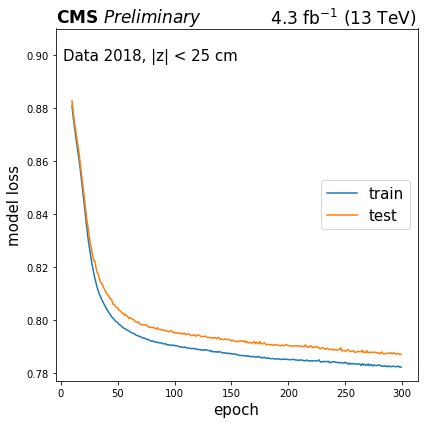

In [23]:
#CMS_state = "Preliminary"

def historyModel(px, ParName):
    xpos, ypos = 0.61, 0.82 # under data
    px.text(0.02,0.9,labelData, size = 15, transform=px.transAxes,
                verticalalignment='bottom', horizontalalignment='left')

    b, t = px.get_ylim()
    px.set_ylim(top = 0.2 * (t-b)+t)
    SetCMSlabel(px)
    px.set_ylabel(ParName)
    px.set_xlabel('epoch')
    px.legend(['train', 'test'], loc='center right')
    
    return

plt.rc('legend', fontsize=15) 
# list all data in history
logger.debug(history_X.keys())
# summarize history for accuracy

# set epoch range
par_acc = np.array(history_X['acc'])
logger.debug("shape acc = " + str(par_acc.shape))
par_val_acc = np.array(history_X['val_acc'])
par_loss = np.array(history_X['loss'])
par_val_loss = np.array(history_X['val_loss'])
par_f1_score = np.array(history_X['f1_score'])
par_val_f1_score = np.array(history_X['val_f1_score'])
par_precision = np.array(history_X['precision'])
par_val_precision = np.array(history_X['val_precision'])
par_recall = np.array(history_X['recall'])
par_val_recall = np.array(history_X['val_recall'])

nEpoch_min = 10
if DataType == "Toy":
    nEpoch_min = 10
nEpoch_max = par_acc.shape[0]
xc         = range(nEpoch_min,nEpoch_max)

fig, (a_loss) = plt.subplots(1,1,  figsize=(6,6))    

# summarize history for loss
a_loss.plot(xc,par_loss[nEpoch_min:nEpoch_max])
a_loss.plot(xc,par_val_loss[nEpoch_min:nEpoch_max])

historyModel(a_loss, 'model loss')

fig.tight_layout()
#fig.tight_layout(pad=1.0)
plt.savefig('Results/' + ModelName + '_history.pdf')
plt.show()

Test and Train loss distributions are very close and are decreasing during training, which shows that model is not over/under trained.

## Model results <a class="anchor" id="ModelResults"></a>
[jump to top](#Top)

Use all NI candidates (Signal, Background, and Unclassified regions) for Train and Test sets, as discussed [this section](#FinalClassification).

### Predict the probability distribution of NN classes for Train and Test sets
<a class="anchor" id="PredictY"></a>
Prediction is done for all regions for the data set, including unclassified region.

The trained model has 2 classes: signal (class 0) and background (class 1), that is why the probability distribution of NN classes should satisfy:

$p_{Signal} + p_{Background} = 1$.

In [24]:
p_hot_Test_pred = model_X.predict(Xnorm_Test_PCA)
p_hot_Train_pred = model_X.predict(Xnorm_Train_PCA)

### The probability distribution for injected vertex to be a signal <a class="anchor" id="PlotY"></a>
[jump to top](#Top)

The probability distribution, $p_{Signal}$, for injected vertex to be a signal for Test set is presented.

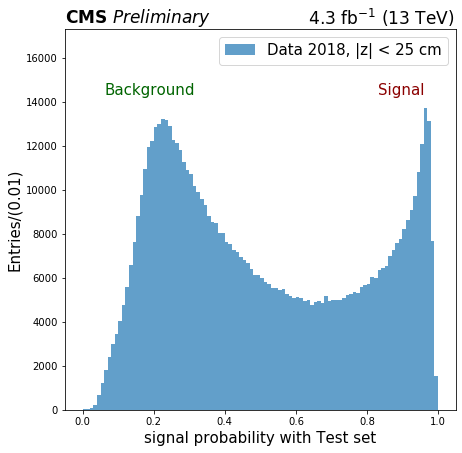

In [25]:
# Signal class:
nclass = 0

Y_Test_pred_nclass = p_hot_Test_pred[:,nclass]
# fig, (ax,bx) = plt.subplots(1,2, figsize=(15,7))
fig, (ax) = plt.subplots(1,1, figsize=(7,7))
num_bins = 100
transperance = 0.7

# n, bins, patches = ax.hist(Y_Train_pred_nclass, 
#                             num_bins, range =[0,1], alpha = transperance)
n, bins, patches = ax.hist(Y_Test_pred_nclass, 
                            num_bins, range =[0,1], alpha = transperance)
b, t = ax.get_ylim()
ax.set_ylim(top = 0.2 * (t-b)+t)
#SetCMSlabel(ax,CMS_state)
SetCMSlabel(ax)
# n, bins, patches = bx.hist(Y_Test_pred_nclass, 
#                             num_bins, range =[1.0e-3,1-1.0e-3], alpha = transperance)
Xtitle = 'signal probability with Test set'
ax.set_xlabel(Xtitle)
ax.set_ylabel('Entries/(%1.2f)'%(bins[1]-bins[0]))
ax.legend([labelData], loc='upper right')
x_B, y_B = 0.1, 0.82
x_S, y_S = 0.8, 0.82
ax.text(x_B, y_B, "Background",
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes, color='darkgreen', fontsize=15)
ax.text(x_S, y_S, "Signal",
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes, color='darkred', fontsize=15)

plt.savefig('Results/' + ModelName +'_SignalProbability.pdf')
plt.show()

### NN model optimization with Test set  <a class="anchor" id="YpredOptimization"></a>
[jump to top](#Top)

Output of the NN is a probability for the NI candidate to be classified as a signal : $p_{Signal}$.

Class prediction, $Y_{predict}$, is defined by $p_{Cut}$ : 
* class 0 (signal):       $p_{Signal}\ge p_{Cut}$;
* class 1 (background):  $p_{Signal}\lt p_{Cut}$.

For signal-background classification $p_{Cut}$ is optimized to maximize 

$f1 score = 2\frac{precision\times recall}{precision + recall}$ , 

calculated on real NIs and combinatorial background, which requires high
precision (purity) = $\frac{\Sigma Y_{true}\times Y_{predict}}{\Sigma Y_{predict}}$
and high recall(efficiency) = $\frac{\Sigma Y_{true}\times Y_{predict}}{\Sigma Y_{true}}$ at the same time. 

Attention: $f1 score$ is calculated on real NIs and combinatorial background, estimated from sidebands, but not on the Signal (mixed sample, which includes combinatorial background) and Background classes prediction ($Y_{predict}$).

* Optimal value for $p_{Signal}$ is 0.47 to separate signal from background. $f1 score$ is calculated with assumption that false-negative prediction (inefficiency)  could be reliably estimated only until 10% from true-positive signal. $Y_{predict}$ is calculated based on this optimal cut. 
* $Y_{predict}$ optimization should be done on the Validation set, but due to lack of data, Train set is used. 

INFO:log:Optimized values: CutSel = 0.47, f1 score = 0.90, and recall = 0.90


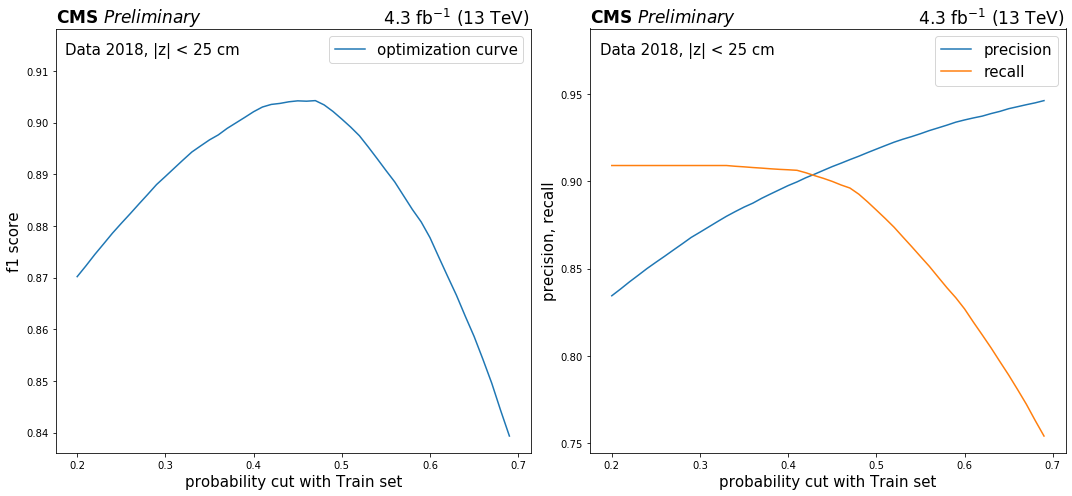

In [26]:
def YpredCut(Y_hot_pred, cutHot):

    if numSig == 1:
        Y_pred = Y_hot_pred[:,0] # signal probability
        Y_pred = 1.*np.invert(Y_pred > cutHot)
    else:
        Y_pred = np.argmax(Y_hot_pred, axis = 1)
    return Y_pred
#for categorical_crossentropy, could make scane from 0.2 to 0.7

Radius_BP_Train, Radius_BPIX_Train, Radius_Tube_Train = CalcRad(X_Train[:,1], X_Train[:,2])[1:4]
Radius_BP_Test, Radius_BPIX_Test, Radius_Tube_Test = CalcRad(X_Test[:,1], X_Test[:,2])[1:4]

# only Train Set is using for optimization:
MaterialforOptimization = ["BP", "L2", "L3", "L4", "Tube", "Rails"]
def f1score_Ypred (Mat, Y_pred, Rad_BP, Rad_BPIX, Rad_Tube, X_Rails):

    # [1] for S estimate, [2] for B_estimate
    S_est_forS, B_est_forS = PreReF1(Rad_BP[Y_pred==0], Rad_BPIX[Y_pred ==0], Rad_Tube[Y_pred ==0], 
                         X_Rails[Y_pred ==0], Mat, MaterialOfPixel)[1:3]
    S_est_forB, B_est_forB = PreReF1(Rad_BP[Y_pred==1], Rad_BPIX[Y_pred ==1], Rad_Tube[Y_pred ==1], 
                         X_Rails[Y_pred ==1], Mat, MaterialOfPixel)[1:3]

    epsilon = 1.0e-6

    # for background classification, signal estimation could be < 0, so make reset to 0 
    # to not confuse calculations, in future better signal estimation should be perform
    scut = 0.10
    S_est_forB[S_est_forB < scut*S_est_forS] = scut*S_est_forS[S_est_forB < scut*S_est_forS]
#     logger.debug("S_est_forB = " +str(S_est_forB))

    
    tp = np.sum(S_est_forS) # Signal, classified as Signal
    fp = np.sum(B_est_forS) # Background, classified as Signal
    fn = np.sum(S_est_forB) # Signal, classified s Background

    prec_Mat = tp / (tp + fp + epsilon)
    recall_Mat = tp / (tp + fn + epsilon)

    f1_Mat = 2*prec_Mat*recall_Mat / (prec_Mat+recall_Mat+epsilon)

    return f1_Mat, prec_Mat, recall_Mat

ymin = 0.2
ymax = 0.7
n_frac = 50
CutSel       = np.zeros(n_frac) 
f1ScoreOpt   = np.zeros(n_frac)
precisionOpt = np.zeros(n_frac)
recallOpt    = np.zeros(n_frac)

f1ScoreMax = -1.
recallMax = -1
CutSel_Opt = -1.

for i in range(0,n_frac):
    CutSel[i] = ymin +i*(ymax-ymin)/n_frac
    Y_Train_pred_Cut = YpredCut(p_hot_Train_pred, CutSel[i])
    f1ScoreOpt[i], precisionOpt[i], recallOpt[i] = f1score_Ypred (MaterialforOptimization, Y_Train_pred_Cut, 
                                                                  Radius_BP_Train, Radius_BPIX_Train, 
                                                                  Radius_Tube_Train, X_Train[:,1])
    if f1ScoreOpt[i] > f1ScoreMax:
        f1ScoreMax = f1ScoreOpt[i]
        CutSel_Opt = CutSel[i]
        recallMax  = recallOpt[i]

# assign predictions for Train and Test sets with optimal cut:
Y_Train_pred = YpredCut(p_hot_Train_pred, CutSel_Opt)
Y_Test_pred = YpredCut(p_hot_Test_pred, CutSel_Opt)

logger.debug("Optimized material: f1score opt = " +str(f1ScoreOpt))
logger.info("Optimized values: CutSel = %3.2f, f1 score = %3.2f, and recall = %3.2f" %
            (CutSel_Opt, f1ScoreMax, recallMax))

fig, (ax,bx) = plt.subplots(1,2,  figsize=(15,7))

ax.plot(CutSel,f1ScoreOpt)
b, t = ax.get_ylim()
ax.set_ylim(top = 0.15 * (t-b)+t)
SetCMSlabel(ax)
ax.legend(["optimization curve"], loc='upper right')
ax.text(0.02,0.93,labelData, size = 15, transform=ax.transAxes,
        verticalalignment='bottom', horizontalalignment='left')
# ax.set_title('Optimization with Train Set for Y prediction')
ax.set_ylabel('f1 score')
ax.set_xlabel('probability cut with Train set')
#ax.legend(['train', 'test'], loc='upper right')

bx.plot(CutSel,precisionOpt)
bx.plot(CutSel,recallOpt)
b, t = bx.get_ylim()
bx.set_ylim(top = 0.15 * (t-b)+t)
#SetCMSlabel(bx,CMS_state)
SetCMSlabel(bx)
bx.text(0.02,0.93,labelData, size = 15, transform=bx.transAxes,
        verticalalignment='bottom', horizontalalignment='left')

bx.set_ylabel('precision, recall')
bx.set_xlabel('probability cut with Train set')
bx.legend(['precision', 'recall'], loc='upper right')

fig.tight_layout()
#fig.tight_layout(pad=1.0)
plt.savefig('Results/' + ModelName + '_Yoptimization.pdf')
plt.show()

### Plot Train and Test prediction for Signal-Background separation as function of  BPIX radius <a class="anchor" id="PlotPredictedResultsR"></a>
[jump to top](#Top)

NN model suppresses background by a factor of 4-5 for Test set, 
and keeps around 90% of  the signal (real NIs).

_Attention:_ NN model wasn’t trained in the signal regions of inner shield and layer 1, but still has similar separation power as for beam pipe region.

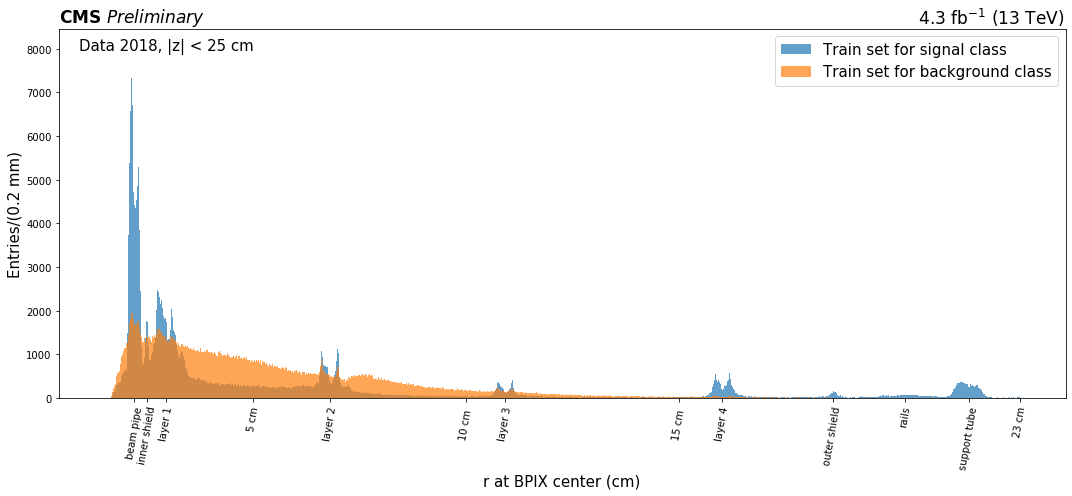

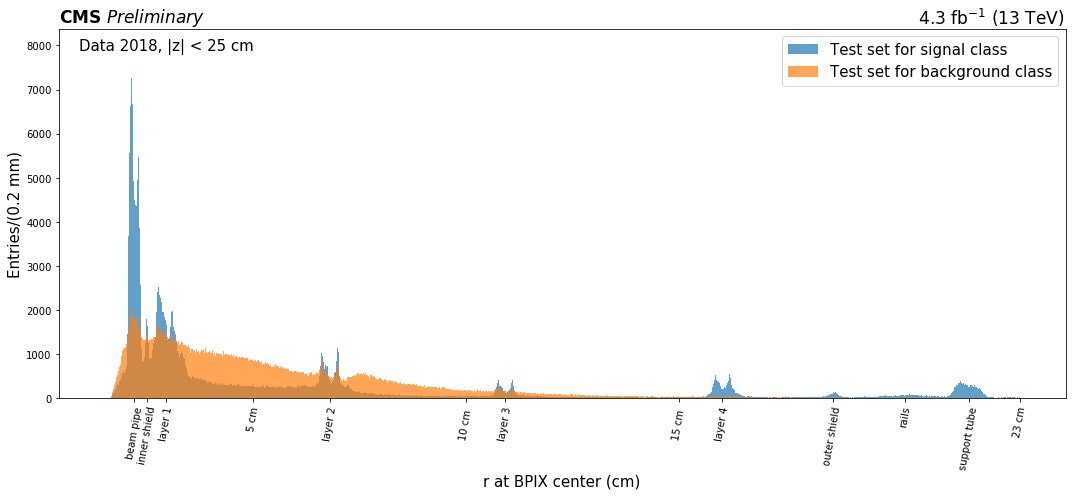

In [27]:
def PlotR_pred(Rad, Y_pred, Rmin, Rmax, Tit, nb):

    fig, (ax) = plt.subplots(1,1, figsize=(15,7))
    num_bins = nb
    transperance = 0.7
    
    #Signal
    n_Sig, bins, patches = ax.hist(Rad[np.logical_and(np.logical_and(Rad > Rmin, Rad < Rmax),
                                                  np.logical_and(Y_pred > -1, Y_pred < numSig))], 
                               num_bins, range =[Rmin,Rmax], alpha = transperance)
    #Background
    n_Bkg, bins, patches = ax.hist(Rad[np.logical_and(np.logical_and(Rad > Rmin, Rad < Rmax),
                                                       np.logical_and(Y_pred > (numSig-1), Y_pred < numClasses))], 
                               num_bins, range =[Rmin,Rmax], alpha = transperance)
           
    b, t = ax.get_ylim()
    ax.set_ylim(top = 0.1 * (t-b)+t)
    SetCMSlabel(ax)
    ax.text(0.02,0.93,labelData, size = 15, transform=ax.transAxes,
            verticalalignment='bottom', horizontalalignment='left')

    Xtitle = 'r at BPIX center (cm)'
    ax.set_xlabel(Xtitle)
    ax.set_ylabel('Entries/(%1.1f mm)'%(10*(bins[1]-bins[0])))
    ax.legend([Tit + ' set for signal class', Tit + ' set for background class'], loc='upper right')

    ax.tick_params(axis='x', which='minor', length=0) # remove minor ticks from 'log' scale
    labBPIX =  ["beam pipe","inner shield", "layer 1", "5 cm", "layer 2", "10 cm ", "layer 3", "15 cm ", 
                "layer 4", "outer shield", "rails", "support tube", "23 cm"]
    xlabBPIX = [        2.2,   2.5,      2.95, 5.0,       6.8,  10.0,     10.9, 15.0,      
                16.0,           18.6,            20.3,     21.8, 23.]
    plt.xticks(xlabBPIX, labBPIX,rotation=80)

    fig.tight_layout()

    plt.savefig('Results/' + ModelName + '_' + Tit + '_Pred.pdf')
    plt.show()


PlotR_pred(Radius_BPIX_Train, Y_Train_pred, 1.5, 23., "Train", 1075)

PlotR_pred(Radius_BPIX_Test, Y_Test_pred, 1.5, 23.,"Test", 1075)
#PlotR_pred(Radius_BP_Test, Y_Test_pred, 1.5, 3.,"Test", 400)
#PlotR_pred(Radius_Tube_Test, Y_Test_pred, 17., 21.,"Test", 100)


### Background to Signal (B/S) ratios in Signal regions (S0-S6)
<a class="anchor" id="BSafterClass"></a>
[jump to top](#Top)

B/S ratios in Signal Regions (S0-S6), discussed in [classification section](#Classification) is estimated from sidebands and is presented for:
* Whole Data set without classification,
* Train set for Signal class of NN prediction, 
* Test set for Signal class of NN prediction.

Significant background suppression is observed in Train/Test sets after NN signal classification.

In [28]:
Mat_All = ["BP", "IS","L1","L2", "L3", "L4","OS", "Tube", "Rails", "Background"] # to avoid changes on MaterialOfInterest_All
del Mat_All[-1]
ratioAll_est = PreReF1(Radius_BP, Radius_BPIX, Radius_Tube, data[:,1],Mat_All, MaterialOfPixel)[0:1]

lenthAll = np.size(ratioAll_est)
extra = ["Background to Signal ratio"]
Mat_All_table = np.r_[np.reshape(extra,(1,)), np.reshape(Mat_All,(lenthAll,))]

extra = ["no classification"]
ratioAll_est = np.round(ratioAll_est,2)
ratio_estAll_table = np.r_[np.reshape(extra,(1,)),np.reshape(np.round(ratioAll_est,2),(lenthAll,))]

# for signal classified at Signal with Train set
ratioTrain_est = PreReF1(Radius_BP_Train[Y_Train_pred == 0], Radius_BPIX_Train[Y_Train_pred == 0], 
                         Radius_Tube_Train[Y_Train_pred == 0], X_Train[:,1][Y_Train_pred == 0],
                         Mat_All, MaterialOfPixel)[0:1]
extra = ["signal class with Train set_"]
ratio_estTrain_table = np.r_[np.reshape(extra,(1,)),np.reshape(np.round(ratioTrain_est,2),(lenthAll,))]

# for signal classified at Signal with Test set
ratioTest_est = PreReF1(Radius_BP_Test[Y_Test_pred == 0], Radius_BPIX_Test[Y_Test_pred == 0], 
                         Radius_Tube_Test[Y_Test_pred == 0], X_Test[:,1][Y_Test_pred == 0],
                         Mat_All, MaterialOfPixel)[0:1]
extra = ["signal class with Test set__"]
ratio_estTest_table = np.r_[np.reshape(extra,(1,)),np.reshape(np.round(ratioTest_est,2),(lenthAll,))]

display_table([Mat_All_table, ratio_estAll_table])
display_table([ratio_estTrain_table])
display_table([ratio_estTest_table])

### Tracker tomography with Test set for Signal-Background separation in x-y plane <a class="anchor" id="PlotPredictedTomography"></a>
[jump to top](#Top)

The signatures of 
* the beam pipe with radius around 2.2 cm, 
* BPIX detector inner shield with radius around 2.5 cm, 
* layer 1 with radius around 3 cm 
* layer 2 with radius around 6.8 cm 
can be observed above the combinatorial background.

Radial lines between layers 1 and 2 are classified as background as expected.

NN model has impressive signal-background separation power.

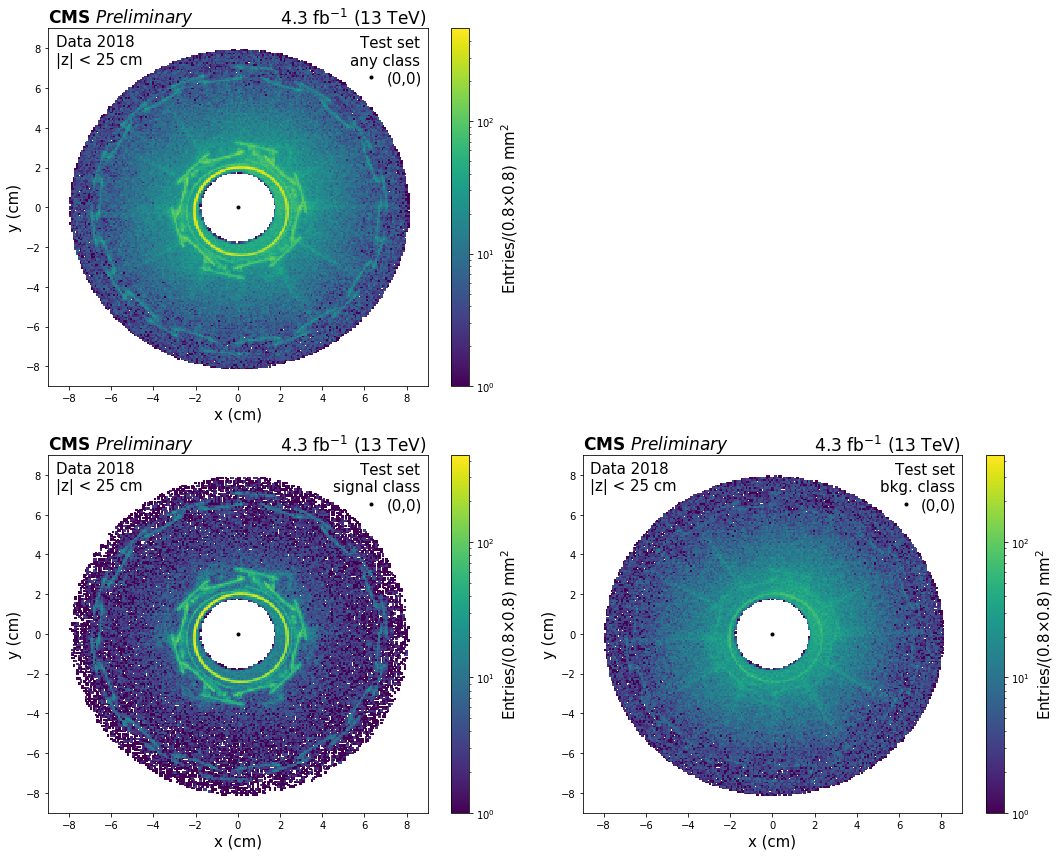

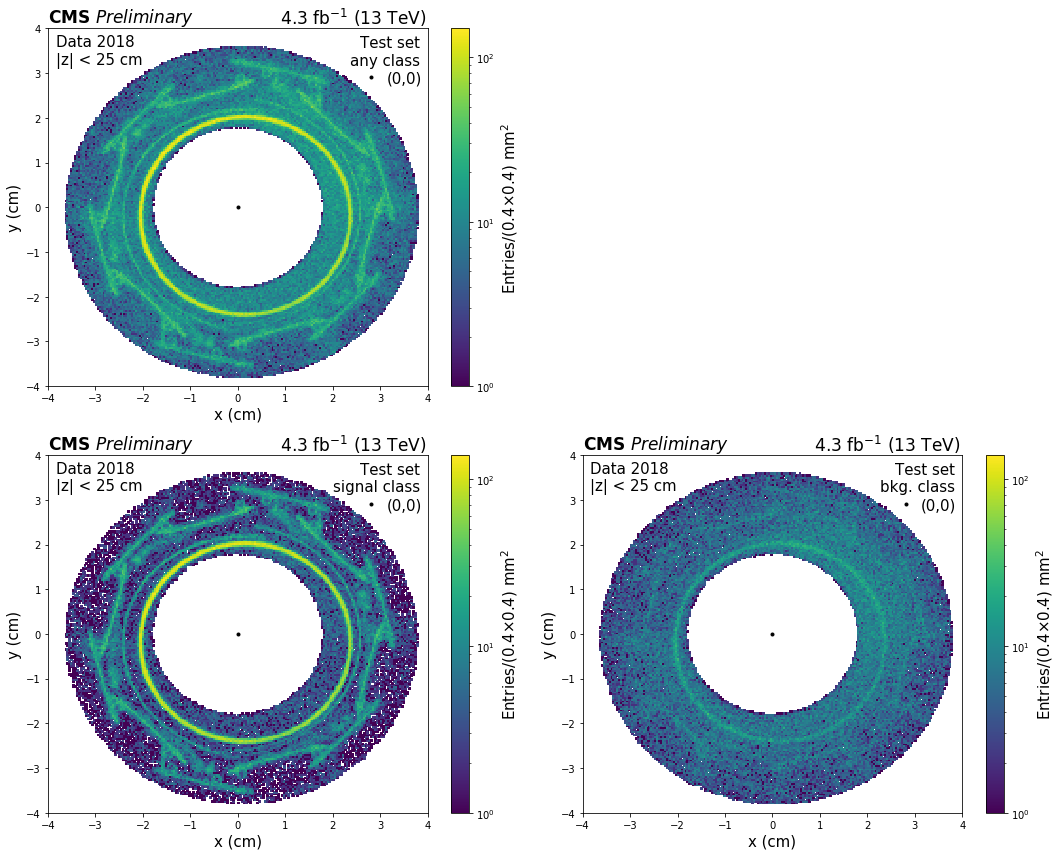

In [29]:
def labelXY(px, Tit, className):
    Xtitle = 'x (cm)'
    Ytitle = 'y (cm)'
    px.set_xlabel(Xtitle)
    px.set_ylabel(Ytitle)

    SetCMSlabel(px)
    if DataType == "Toy":
        t = px.text(0.02,0.89,"Toy Data", size = 15, transform=px.transAxes, 
                verticalalignment='bottom', horizontalalignment='left')
    else:
        t = px.text(0.02,0.89,"Data 2018\n|z| < 25 cm", size = 15, transform=px.transAxes, 
                verticalalignment='bottom', horizontalalignment='left')
    t = px.text(0.98,0.89,Tit + " set\n"+className+" class", size = 15, transform=px.transAxes, 
            verticalalignment='bottom', horizontalalignment='right')
#     t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))
    x0 = [0]
    y0 = [0]
    px.plot(x0,y0, color = 'black',marker='o', markersize=3, linestyle="None", label = "(0,0)")
    px.legend(loc='upper right',bbox_to_anchor=(1.02, 0.92),handletextpad=0.0,framealpha=0.)
#     bug: \bullet and \cdot plots as square...
#     t = px.text(0.98,0.83,r"$\bf{\bullet}$"+" (0,0)", size = 15, transform=px.transAxes, 
#             verticalalignment='bottom', horizontalalignment='right')
#     t = px.text(0.98,0.83,"${\cdot}$"+" (0,0)", size = 15, transform=px.transAxes, 
#             verticalalignment='bottom', horizontalalignment='right')

def PlotXY(x, y, Y_pred, Xmax, Rcut, Tit, nb):
    # using the variable ax for single a Axes
    fig, ((ax, a_null),(bx,dx)) = plt.subplots(2,2, figsize=(15,12))
    fig.delaxes(a_null)
    num_bins = nb

    Rad = CalcRad(x, y)[2] # 2nd element centered at BPIX
    cut = Rcut
    xcut = x[Rad < cut]
    ycut = y[Rad < cut]
    Y_cut = Y_pred[Rad < cut]
    x0 = [0]
    y0 = [0]
# to add color pallete to figure: cmap = 'viridis' (default), 'jet'    
    counts, xedges, yedges, im = ax.hist2d(xcut, ycut, bins=nb, range = [[-Xmax, Xmax], [-Xmax, Xmax]], norm=LogNorm(),
                                          cmap = 'viridis')
    
    counts, xedges, yedges, im2 = bx.hist2d(xcut[np.logical_and(Y_cut > -1, Y_cut < numSig)], 
                                           ycut[np.logical_and(Y_cut > -1, Y_cut < numSig)], bins=nb,
                                            range = [[-Xmax, Xmax], [-Xmax, Xmax]], norm=LogNorm())

    counts, xedges, yedges, im3 = dx.hist2d(xcut[np.logical_and(Y_cut > (numSig-1), Y_cut < numClasses)], 
                                           ycut[np.logical_and(Y_cut > (numSig-1), Y_cut < numClasses)], bins=nb, 
                                            range = [[-Xmax, Xmax], [-Xmax, Xmax]], norm=LogNorm())

    vmin, vmax = im2.get_clim()
    im3.set_clim(vmin, vmax)
    ax_cbar = plt.colorbar(im, ax=ax)
    wbin = 2*Xmax/nb
    cbarTitle = r'Entries/(%1.1f$\times$%1.1f) mm$^2$'%(10*wbin, 10*wbin)
    ax_cbar.ax.set_ylabel(cbarTitle)
    bx_cbar = plt.colorbar(im2, ax=bx)
    bx_cbar.ax.set_ylabel(cbarTitle)
    dx_cbar = plt.colorbar(im3, ax=dx)
    dx_cbar.ax.set_ylabel(cbarTitle)

    labelXY(ax, Tit, 'any')
    labelXY(bx, Tit, 'signal')
    labelXY(dx, Tit, 'bkg.')
    
    fig.tight_layout()
    plt.savefig('Results/' + ModelName + '_' + Tit + '_size'+str(Xmax)+'_XY_Pred.pdf')
    plt.show()

#PlotXY(X_Test[:,1], X_Test[:,2], Y_Test_pred, 25., 23., "Test", 1250)
PlotXY(X_Test[:,1], X_Test[:,2], Y_Test_pred, 9., 8., "Test", 225)
PlotXY(X_Test[:,1], X_Test[:,2], Y_Test_pred, 4., 3.7, "Test", 200)

###[//]: # 'Nice link to citing packages in the SciPy ecosystem: https://www.scipy.org/citing.html'

# Summary <a class="anchor" id="Summary"></a>

* Machine learning method for reducing combinatorial background in data without Monte Carlo is presented:

  * <font color='red'>NN model with floating classification on the mixed samples</font> is constructed
  * Even though the variables used for the training show only small differences between background and signal, the NN has impressive separation power
  * NN model wasn’t trained in the signal regions of inner shield and layer 1, but still has similar separation power as for beam pipe region.
  * Combinatorial background suppression could decrease systematic uncertainties for material position and material density measurements
  * This technique could be used for any analysis, where you could perform classification on mixed samples with different ratios of background to signal
  
[jump to top](#Top)
  
# Documentation <a class="anchor" id="Doc"></a>

* **A guide to NumPy.** Travis E. Oliphant. USA: Trelgol Publishing, (2006), http://www.numpy.org/

* **The NumPy Array: A Structure for Efficient Numerical Computation.** Stéfan van der Walt, S. Chris Colbert and Gaël Varoquaux. Computing in Science & Engineering, 13, 22-30 (2011), [DOI:10.1109/MCSE.2011.37](https://ieeexplore.ieee.org/document/5725236)

* **Matplotlib: A 2D Graphics Environment.** John D. Hunter., Computing in Science & Engineering **9** (2007) 90-95, [DOI:10.1109/MCSE.2007.55](https://ieeexplore.ieee.org/document/4160265)

* **Keras.** Chollet, François and others (2015), https://keras.io

* **Precision measurement of the structure of the CMS inner tracking system using nuclear interactions.** CMS Collaboration. JINST **13** (2018) 10034, [DOI:10.1088/1748-0221/13/10/P10034](http://dx.doi.org/10.1088/1748-0221/13/10/P10034)

* **Precision measurement of the structure of the CMS inner tracking system using nuclear interactions with data collected in 2018.** CMS Collaboration. [CERN-CMS-DP-2019-001](http://cds.cern.ch/record/2664786?ln=en)

* **Jupyter Notebooks – a publishing format for reproducible computational workflows.** T. Kluyver, B. Ragan-Kelley and others. IOS Press (2016) 87, [DOI:10.3233/978-1-61499-649-1-87](http://ebooks.iospress.nl/publication/42900)

* **SWAN: A service for interactive analysis in the cloud**. Future Generation Computer Systems **78 part 3** (2018) 1071, [DOI:10.1016/j.future.2016.11.035](https://doi.org/10.1016/j.future.2016.11.035)

* **2017 tracking performance plots**. CMS Collaboration. [CERN-CMS-DP-2017-015](https://cds.cern.ch/record/2290524?ln=en)

* **Classification without labels: Learning from mixed samples in high energy physics.** Eric M. Metodiev, Benjamin Nachman, Jesse Thaler. JHEP **10** (2017) 174 [DOI:10.1007/JHEP10(2017)174](https://doi.org/10.1007/JHEP10(2017)174)

[jump to top](#Top)

# Acknowledgment <a class="anchor" id="Acknowledgment"></a>

We are grateful to support from the National Science Foundation.

[jump to top](#Top)
